This file contains time series analysis for the combined dog adoption data from Austin, TX and austin, CA.

We use a combination of baseline models and other more advanced ones (see below). We also include models from extreme value analysis, inspired by "Modeling Extreme Events in Time Series and Their Impact on Seasonal Adjustment in the Post-Covid-19 Era", Anindya Roy,and Tucker S. McElroy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

from datetime import datetime

set_style("whitegrid")

In [2]:
# read csv and change date columns into dtype = datetime64
df = pd.read_csv("../main_data/CleanedDataOnePlace.csv", parse_dates=["Date"])

/tmp/ipykernel_50890/1664856861.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../main_data/CleanedDataOnePlace.csv", parse_dates=["Date"])


In [3]:
df.head()

Date  SonomaIntakeTotals  SonomaOutcomeTotals  SonomaDifferences  \
0 2013-10-01                 NaN                  NaN                NaN   
1 2013-10-02                 NaN                  NaN                NaN   
2 2013-10-03                 NaN                  NaN                NaN   
3 2013-10-04                 NaN                  NaN                NaN   
4 2013-10-05                 NaN                  NaN                NaN   

   SonomaRatio  Sonoma_intake_stray_abandoned  Sonoma_intake_owner_surrender  \
0          NaN                            NaN                            NaN   
1          NaN                            NaN                            NaN   
2          NaN                            NaN                            NaN   
3          NaN                            NaN                            NaN   
4          NaN                            NaN                            NaN   

   Sonoma_intake_euthanasia  Sonoma_intake_public_assist  \
0                       NaN                          NaN   
1                       NaN                          NaN   
2                       NaN                          NaN   
3                       NaN                          NaN   
4                       NaN                          NaN   

   Sonoma_intake_other_i  ...  Austin_Owner_Surrender  Austin_Other  \
0                    NaN  ...                     9.0           0.0   
1                    NaN  ...                     4.0           0.0   
2                    NaN  ...                     3.0           0.0   
3                    NaN  ...                     6.0           0.0   
4                    NaN  ...                     8.0           0.0   

   Austin_Adopt  Austin_Euth  Austin_RTO  Austin_Unintended  Austin_Other.1  \
0           6.0          7.0        11.0                0.0             5.0   
1          12.0          2.0         9.0                0.0            10.0   
2           7.0          0.0         6.0                0.0             5.0   
3           6.0          3.0         9.0                0.0             5.0   
4          22.0          2.0         6.0                0.0             8.0   

   Inflation Rate  Unemployment Rate  Covid  
0             1.0                7.2    0.0  
1             1.0                7.2    0.0  
2             1.0                7.2    0.0  
3             1.0                7.2    0.0  
4             1.0                7.2    0.0  

[5 rows x 32 columns]

In [4]:
# Choose dates where both data agree
df = df.loc[(df["Date"] >= pd.Timestamp(year = 2014, month = 1, day =1)) & (df["Date"] <= pd.Timestamp(year = 2024, month = 5, day =1))]

# df = df[df["SonomaRatio"].notna() & df["AustinRatio"].notna()]

# This column contains nans and np.inf, since there are no outcomes data on certain days. fill with 0
df = df.fillna(value={"AustinOutcomeTotal":0})

# Recompute ratios for Sonoma and Austin
df["SonomaRatio"] = df["SonomaIntakeTotals"] / df["SonomaOutcomeTotals"]
df["AustinRatio"] = df["AustinIntakeTotal"] / df["AustinOutcomeTotal"]

# There are some divisions by 0, replace by nan and remove such rows
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df[df["SonomaRatio"].notna() & df["AustinRatio"].notna() & df["SonomaRatio"]].reset_index(drop=True)

In [5]:
df["SonomaLogRatio"] = np.log(df["SonomaRatio"])
df["AustinLogRatio"] = np.log(df["AustinRatio"])

In [6]:
col_list = ["SonomaIntakeTotals", "SonomaOutcomeTotals","SonomaDifferences","SonomaRatio", "SonomaLogRatio","AustinIntakeTotal","AustinOutcomeTotal","AustinDifferences","AustinRatio", "AustinLogRatio"]

In [7]:
daily_maxmindiff = (df[col_list].max(axis=0) - df[col_list].min(axis=0))

## (0) Goal:
- TSA for intakes, outcomes, intakes - outcomes, intakes/outcomes
    - Sonoma
    - Austin
    - Combined?
- baseline models
    - naive (use last value)
    - average
    - trend
    - random walk
    - random walk with drift
    - seasonal???
- other models
- EVA models
- compare with features:
    - CPI
    - unemployment
    - stock prices
    - intake subtypes?
    - etc.

Let's begin with some data visualisation of the two regions.

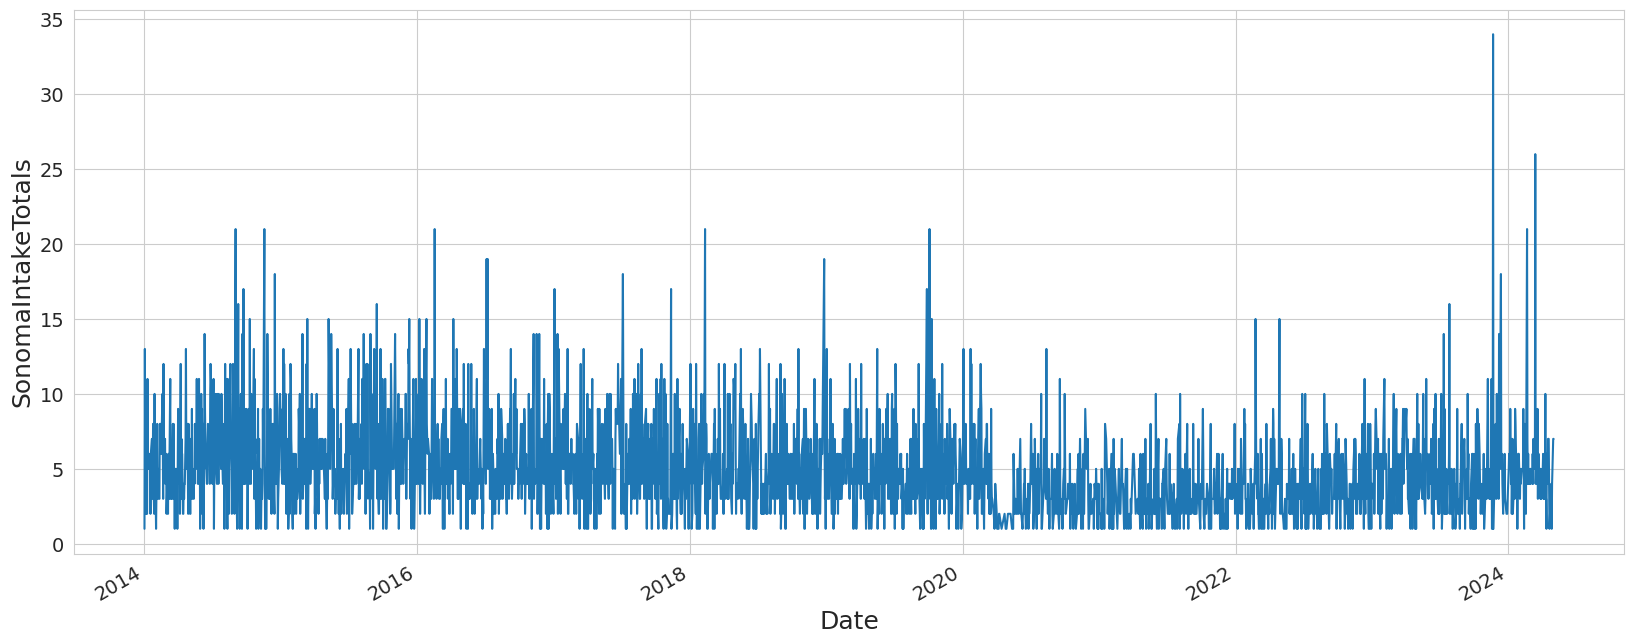

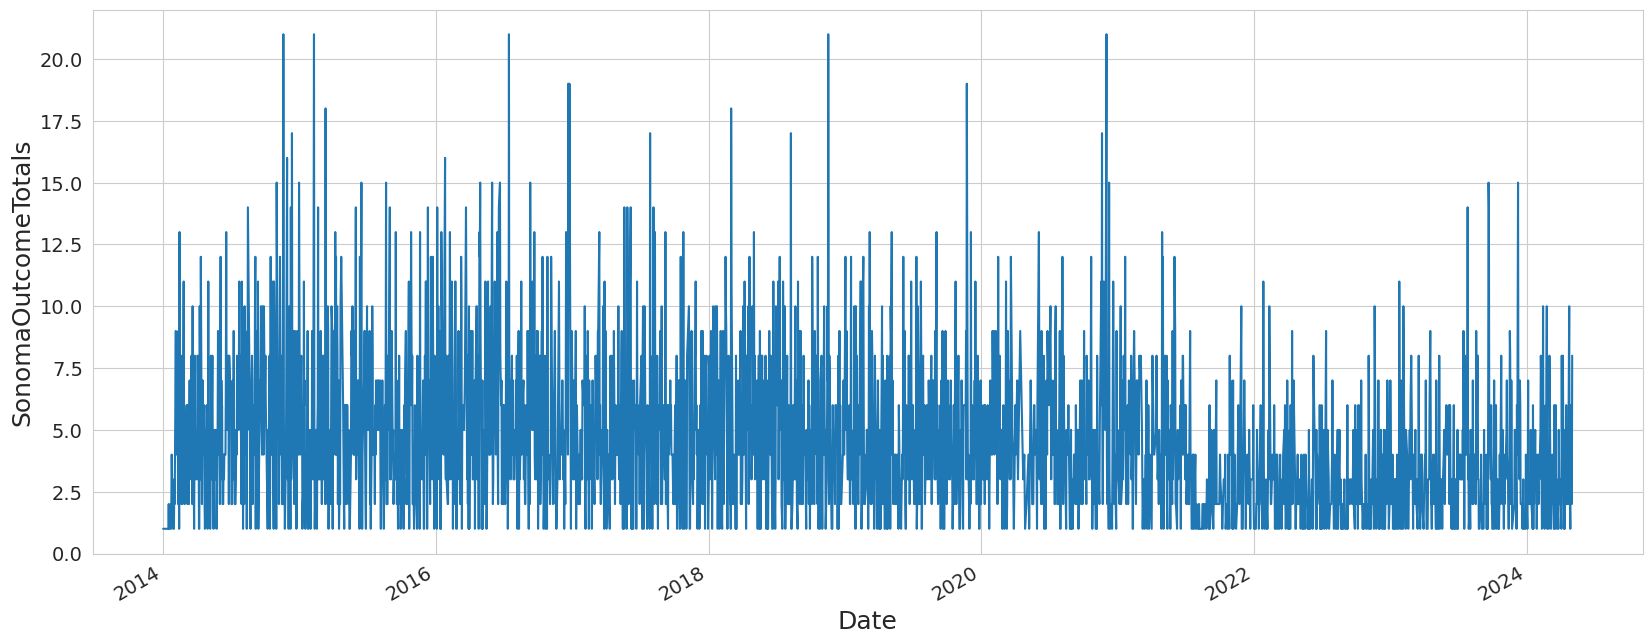

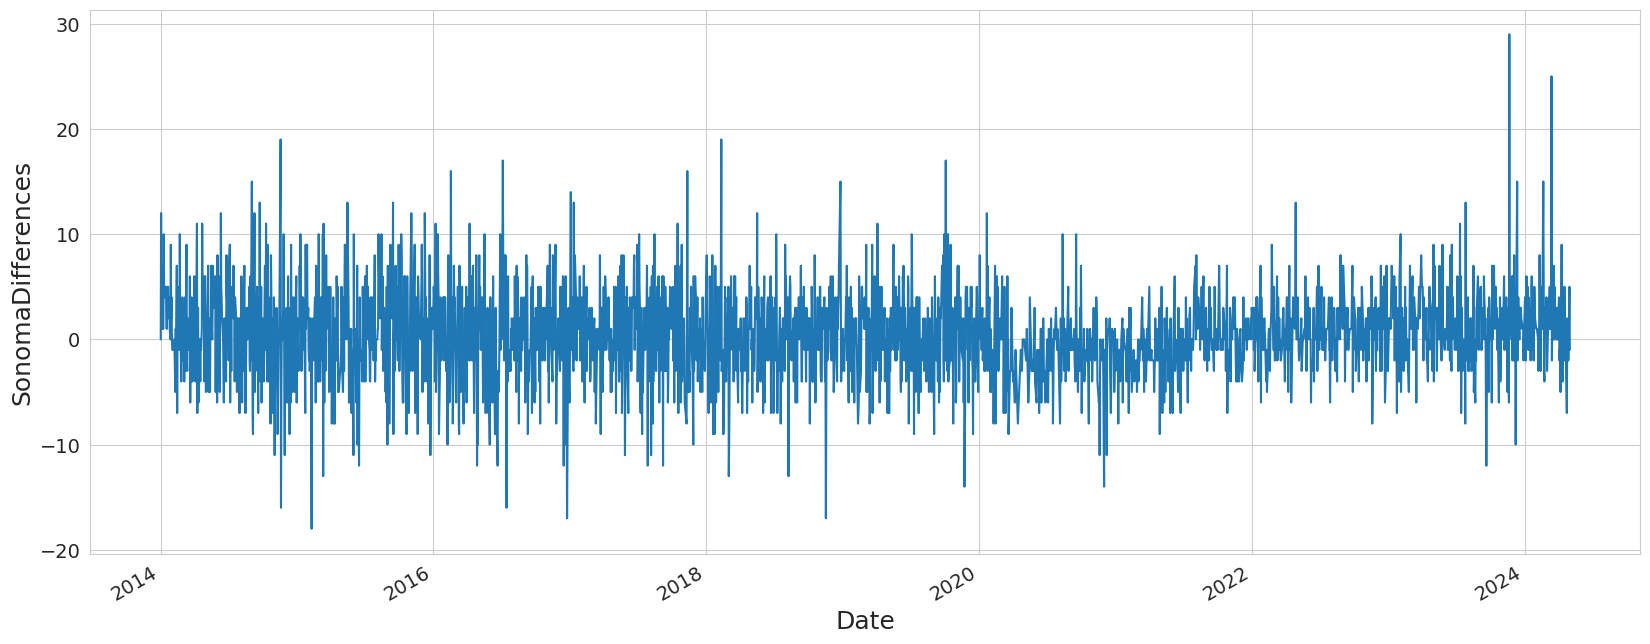

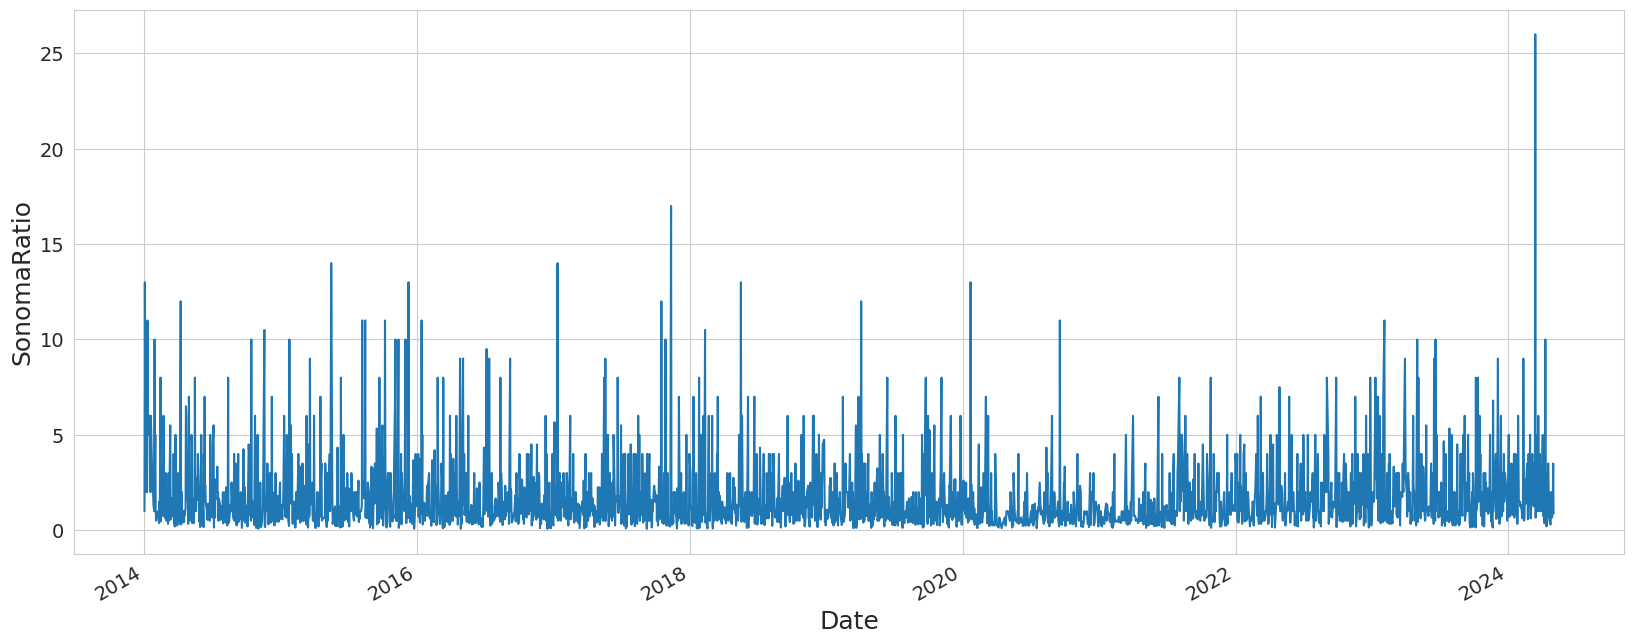

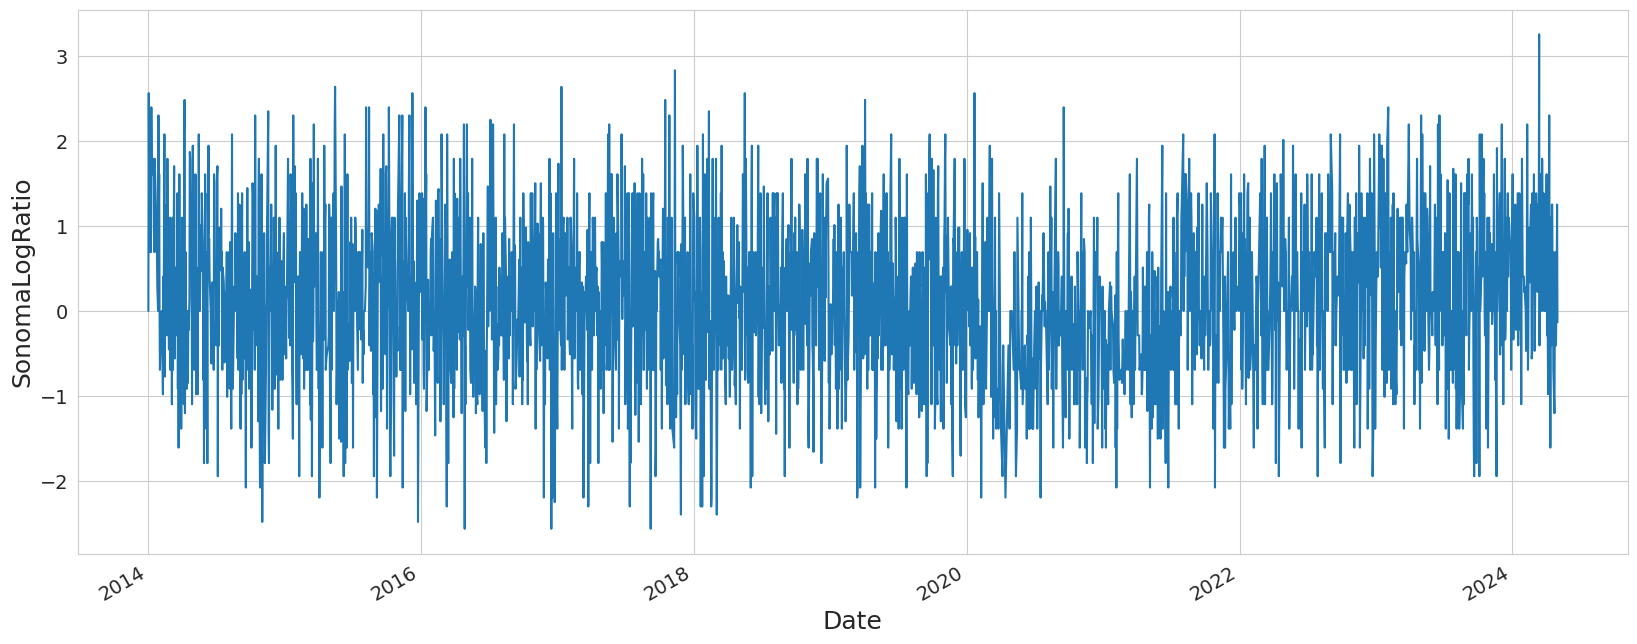

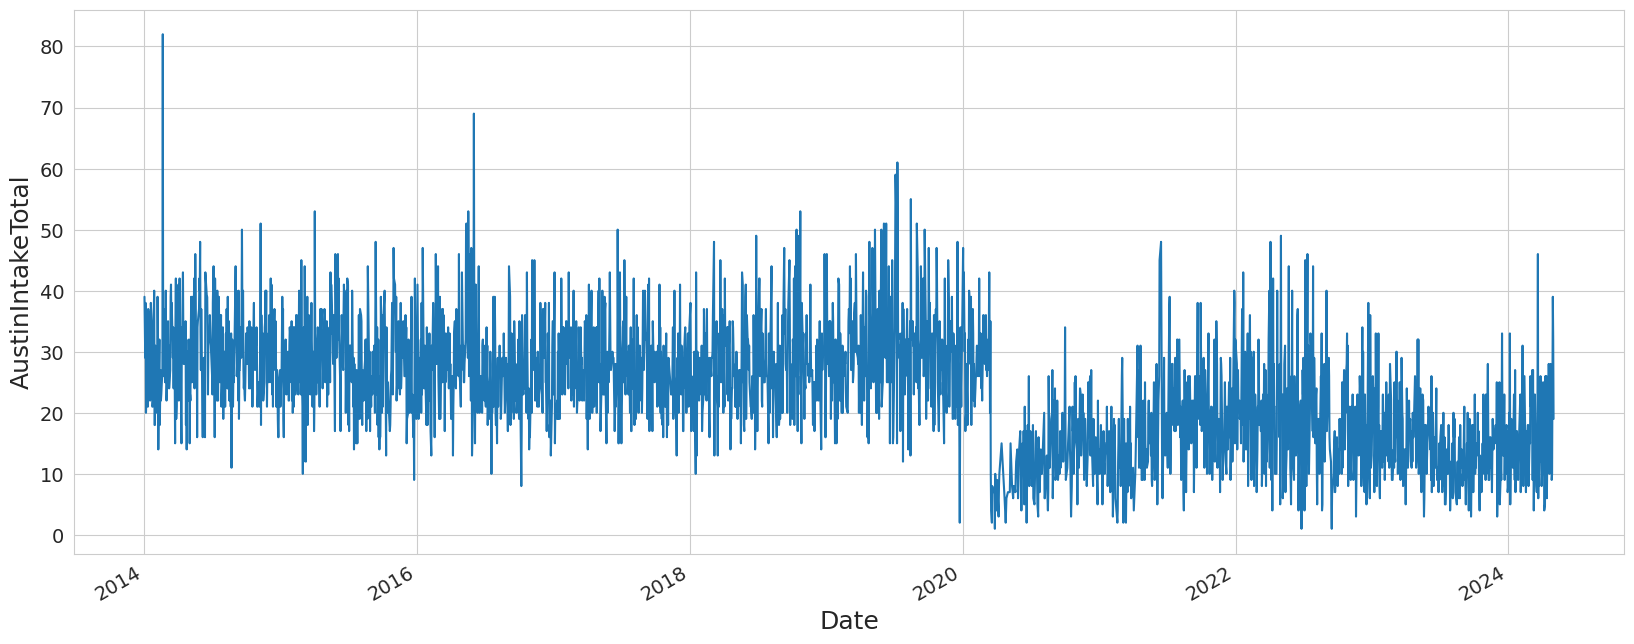

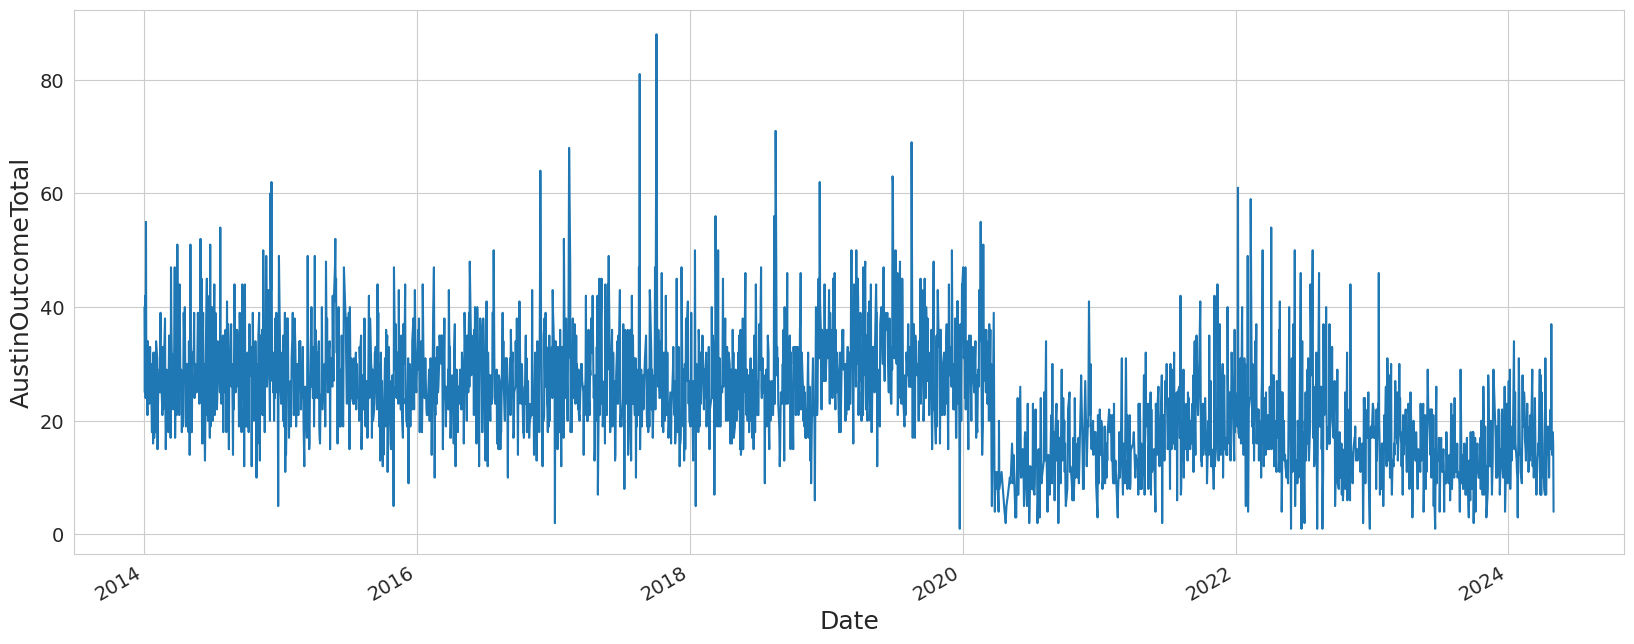

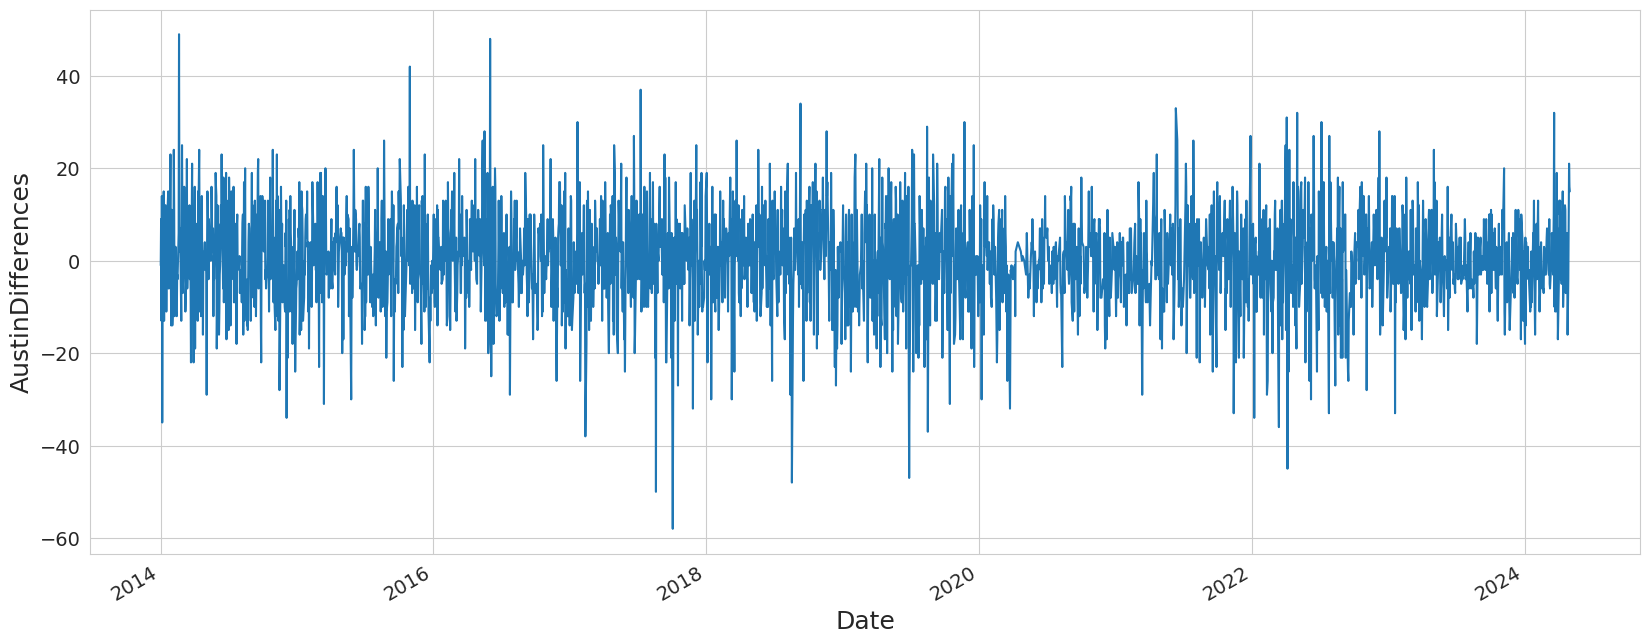

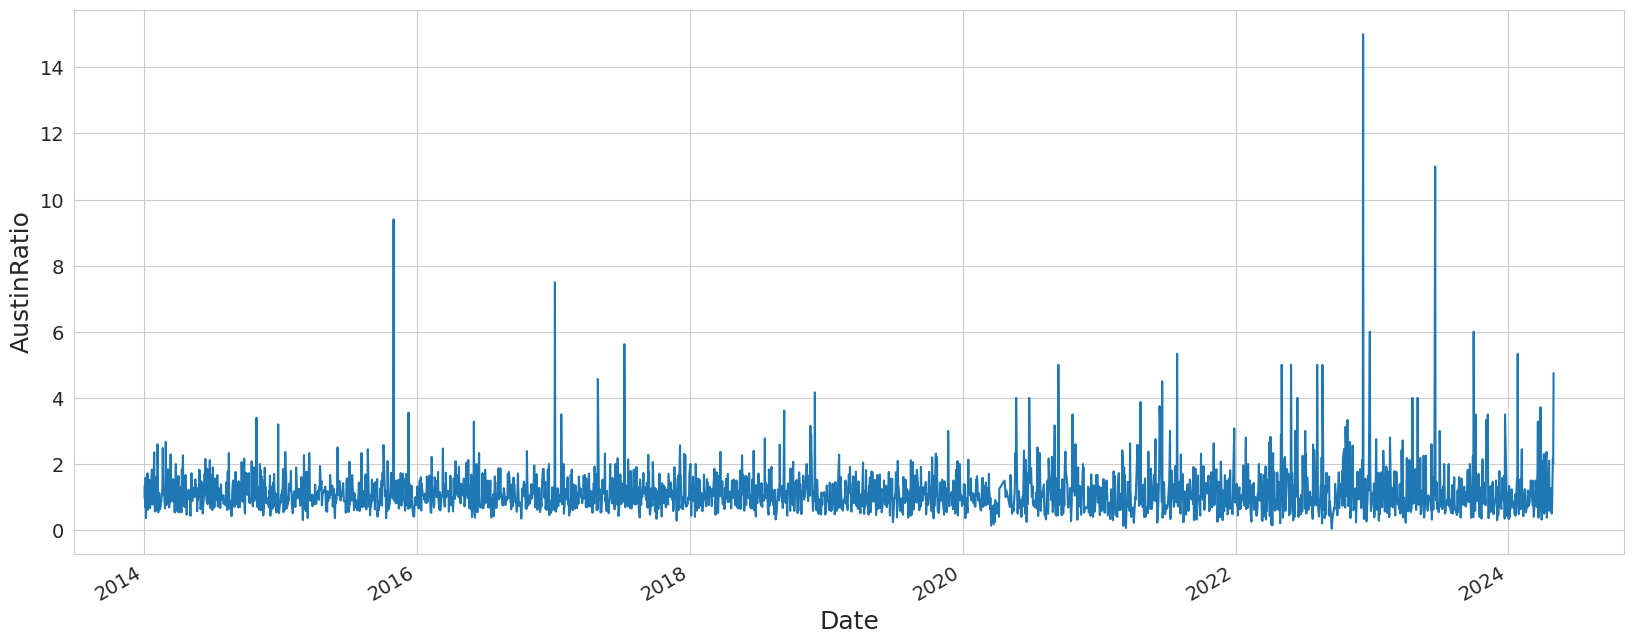

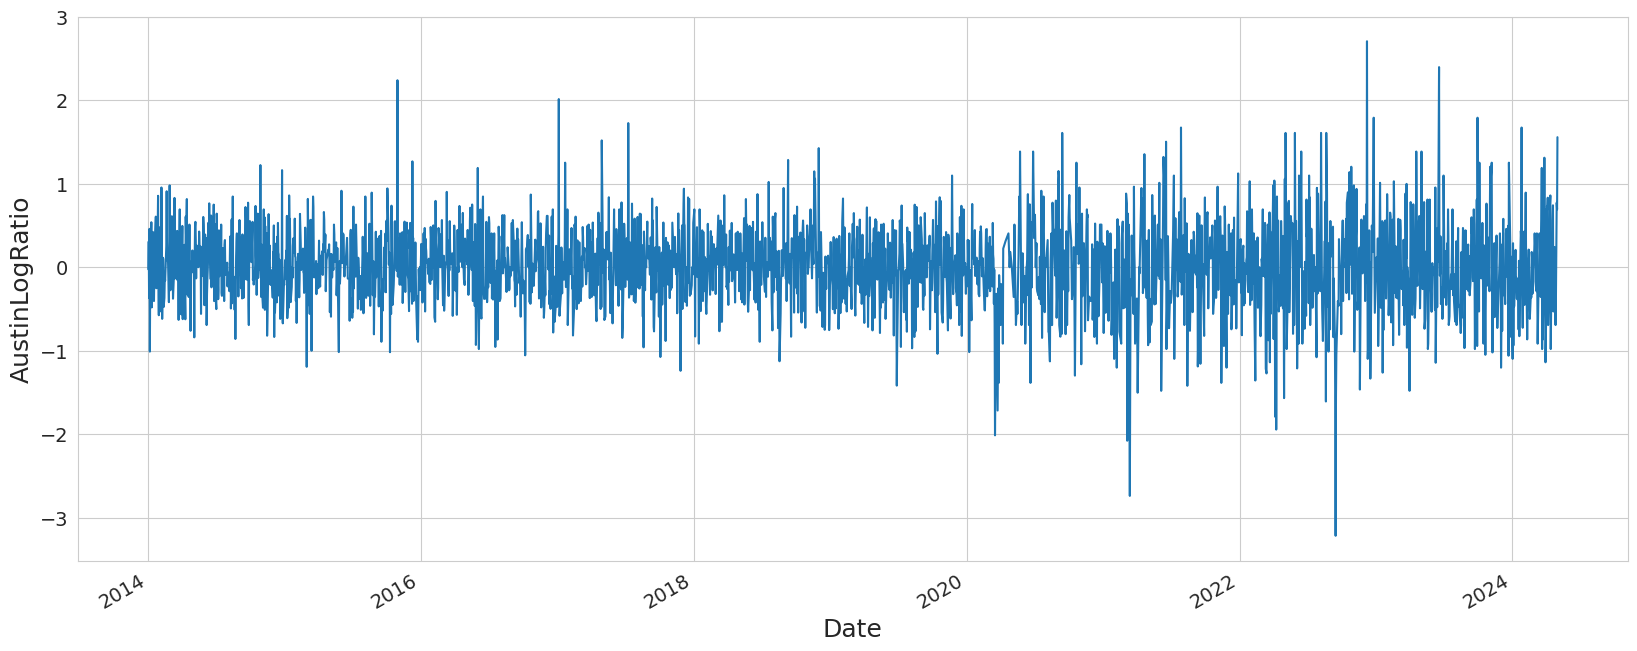

In [8]:
for col in col_list:
    plt.figure(figsize=(20,8))
    plt.plot(df["Date"], df[col])

    plt.xlabel("Date", fontsize=18)
    plt.ylabel(col, fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gcf().autofmt_xdate()

    plt.show()

Sonoma data is "noisier" than Austin's, most likely due to size of data in both regions. One could observe that there is a significant change when COVID-19 (March 16 2020) measures were in place.

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [10]:
# k = 5
# test size = 14 days
kfold = TimeSeriesSplit(n_splits = 100,
                           test_size = 14)

In [11]:
df_train = df.iloc[:-14].copy()
df_test = df.drop(df_train.index).copy()

## (1) Baseline models
1. Average : y_t = ybar for t >= n
2. Naive : y_t = y_n for t >= n
3. Linear : y_t = beta_0 + beta_1 * t for t >= n
4. (Gaussian) random walk with drift: y_t = y_n + beta_1* (t-n) where beta_1 = 1/n (y_n - y_0)

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
avg_rmses= np.zeros((10,100))
naive_rmses= np.zeros((10,100))
slr_rmses= np.zeros((10,100))
rw_drift_rmses= np.zeros((10,100))

i = 0
for train_index, test_index in kfold.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    for j in range(len(col_list)):
        
        # 1. Average forecast
        # forecast using average of training set
        df_tt_avg = df_tt[col_list[j]].mean()
        avg_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]].values, df_tt_avg*np.ones(len(df_ho))))
        
        # 2. Naive forecast
        # forecast using last value of training set
        df_tt_naive = df_tt[col_list[j]].values[-1]
        naive_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]].values, df_tt_naive*np.ones(len(df_ho))))
        
        
        # 3. Linear trend forecast
        # coefficients estimated through linear regression on training set
        slr = LinearRegression()
        slr.fit(np.array(df_tt.index).reshape(-1,1),
                df_tt[col_list[j]])
        pred = slr.predict(np.array(df_ho.index).reshape(-1,1))
        slr_rmses[j,i] = np.sqrt(mean_squared_error( df_ho[col_list[j]], pred))
        
        # 4. (Gaussian) random walk with drift
        beta_hat = (df_tt[col_list[j]].values[-1] - df_tt[col_list[j]].values[0])/len(df_tt)
        drift_pred = df_tt[col_list[j]].values[-1] + beta_hat*np.arange(1,len(df_ho) + 1)
        rw_drift_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]], drift_pred))
                
    i += 1
    
print(" Average: \n", avg_rmses.mean(axis=1))
print(" Naive: \n",naive_rmses.mean(axis=1))
print(" Linear: \n",slr_rmses.mean(axis=1))
print(" Random walk with drift: \n", rw_drift_rmses.mean(axis=1))

 Average: 
 [ 2.89664137  2.82466534  3.65008514  1.63566577  0.91355567 11.12746148
 11.17912055  9.77219194  0.68489104  0.53861994]
 Naive: 
 [ 3.48097797  3.39265103  5.06555599  2.17975223  1.24767584 10.0341243
 10.73562274 13.74536639  0.94606191  0.75043555]
 Linear: 
 [2.67302703 2.59986129 3.66572935 1.6172581  0.91563982 9.06072149
 9.34660525 9.7716717  0.68562657 0.53856764]
 Random walk with drift: 
 [ 3.48564836  3.39853638  5.07451273  2.18273959  1.2497529  10.05118442
 10.75701656 13.76829292  0.94744639  0.75161672]


## (2) Spicy stuff

- first decide on stationarity, autocorrelation
- (M)oving (A)verage model ?
- (A)uto (R)egressive model ?
- (S)ARIMA ?

In [14]:
import statsmodels.api as sm

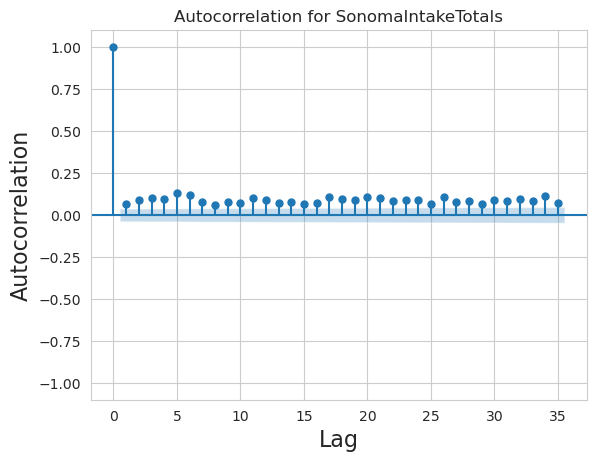

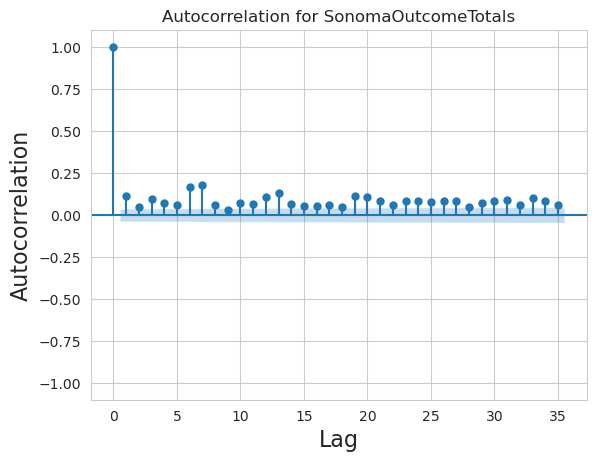

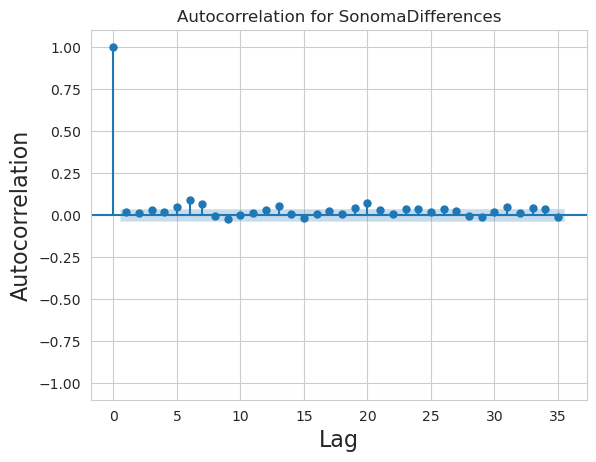

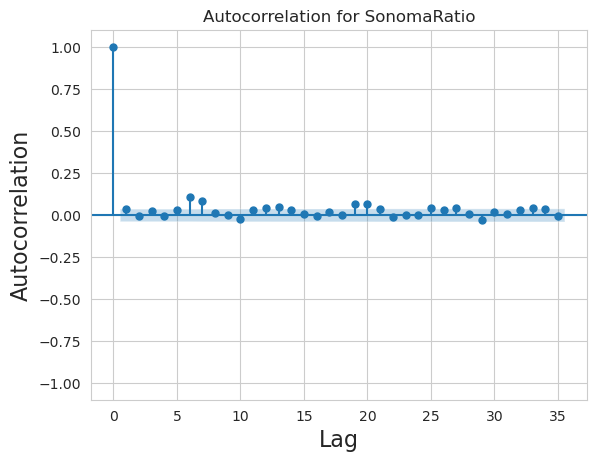

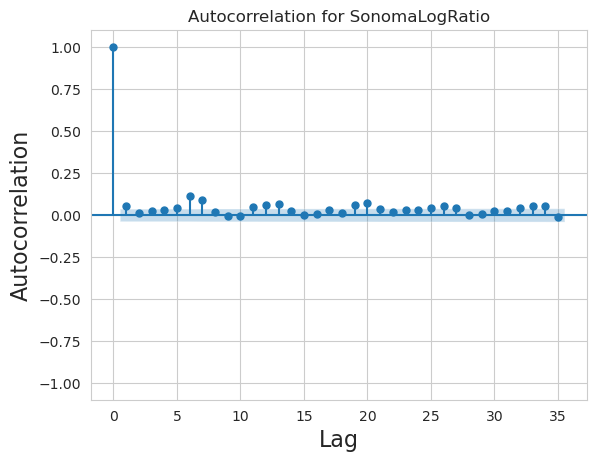

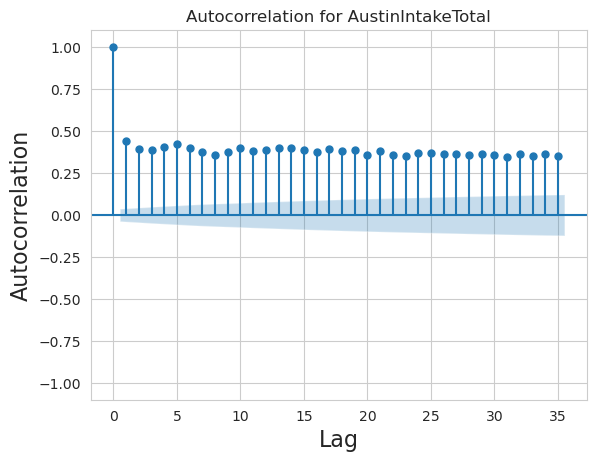

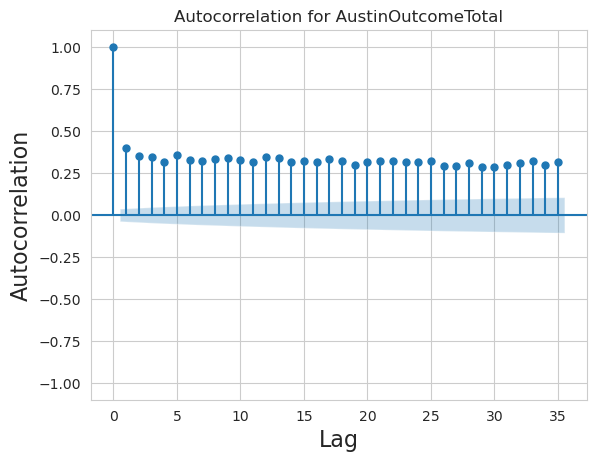

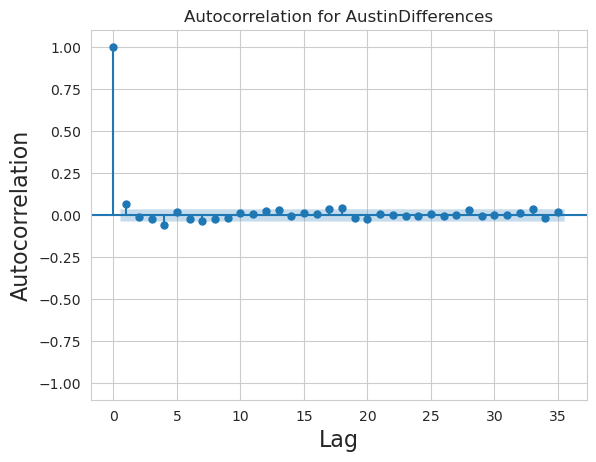

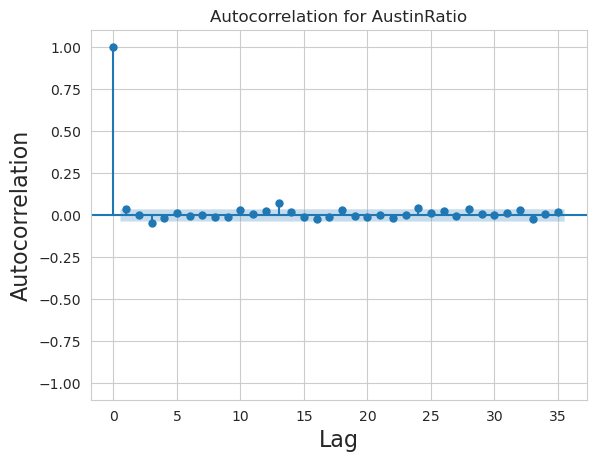

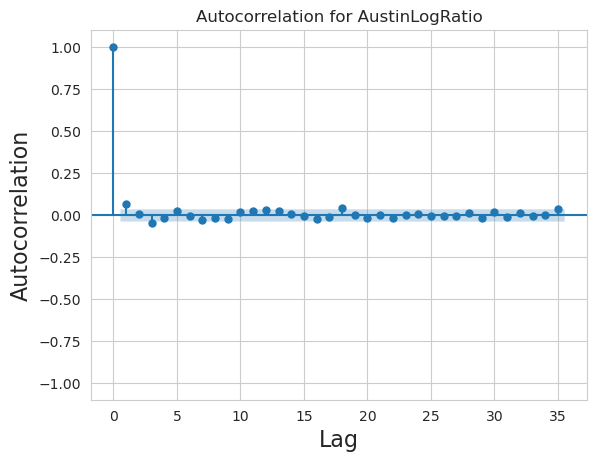

In [15]:
# Autocorrelation plots for starionarity and autocorrelation
for col in col_list:
    sm.graphics.tsa.plot_acf(df_train[col],
                                lags = 35)

    plt.title('Autocorrelation for ' + col, fontsize=12)
    plt.ylabel("Autocorrelation", fontsize=16)
    plt.xlabel("Lag", fontsize=16)

    plt.ylim(-1.1,1.1)

    plt.show()

### Observations:

Sonoma:
- Differences and LogRatio appear to be random
- All are stationary - declined to nonsignificant levels very quickly
- no seasonality (up to 35 days)

Austin:
- Differences and LogRatio (and Ratio) appear to be random
- The rest seem to be nonstationary - slow decline of autocorrelations
- no seasonality (up to 35 days)


In [16]:
# No seasonality observed, use auto_arima to find the optimal hyperparameters
from pmdarima import auto_arima
import statsmodels.tsa.api as sm

In [17]:
for i in range(len(col_list)):
    print(col_list[i])
    auto_arima(df_train[col_list[i]], trace=True)

SonomaIntakeTotals
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14028.065, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15969.083, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15130.314, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14024.343, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15967.083, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14024.600, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14024.595, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14028.287, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14022.358, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14022.612, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14022.606, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15128.314, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14024.605, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.87

In [18]:
# ARIMA hyperparameters from the above cell
sonoma_intake_arima_model = sm.ARIMA(df_train["SonomaIntakeTotals"], order = (0,1,1)).fit()
sonoma_outcome_arima_model = sm.ARIMA(df_train["SonomaOutcomeTotals"], order = (0,1,3)).fit()
sonoma_diff_arima_model = sm.ARIMA(df_train["SonomaDifferences"], order = (0,1,1)).fit()
sonoma_ratio_arima_model = sm.ARIMA(df_train["SonomaRatio"], order = (0,1,1)).fit()
sonoma_logratio_arima_model = sm.ARIMA(df_train["SonomaLogRatio"], order = (0,1,1)).fit()
austin_intake_arima_model = sm.ARIMA(df_train["AustinIntakeTotal"], order = (0,1,2)).fit()
austin_outcome_arima_model = sm.ARIMA(df_train["AustinOutcomeTotal"], order = (1,1,1)).fit()
austin_diff_arima_model = sm.ARIMA(df_train["AustinDifferences"], order = (2,0,1)).fit()
austin_ratio_arima_model = sm.ARIMA(df_train["AustinRatio"], order = (5,1,0)).fit()
austin_logratio_arima_model = sm.ARIMA(df_train["AustinLogRatio"], order = (2,0,2)).fit()

arima_models = [sonoma_intake_arima_model,
                sonoma_outcome_arima_model,
                sonoma_diff_arima_model,
                sonoma_ratio_arima_model,
                sonoma_logratio_arima_model,
                austin_intake_arima_model,
                austin_outcome_arima_model,
                austin_diff_arima_model,
                austin_ratio_arima_model,
                austin_logratio_arima_model]

/home/jun/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jun/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [19]:
# Record ARIMA rmse's
arima_rmses= np.zeros((10,100))

i = 0
for train_index, test_index in kfold.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    for j in range(len(col_list)):
        
        # ARIMA forecast
        arima_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]].values, arima_models[j].forecast(len(df_ho))))
                
    i += 1

RMSE's of all models used:

In [20]:
print(" Average: \n", avg_rmses.mean(axis=1))
print(" Naive: \n",naive_rmses.mean(axis=1))
print(" Linear: \n",slr_rmses.mean(axis=1))
print(" Random walk with drift: \n", rw_drift_rmses.mean(axis=1))
print(" ARIMA: \n", arima_rmses.mean(axis=1))

 Average: 
 [ 2.89664137  2.82466534  3.65008514  1.63566577  0.91355567 11.12746148
 11.17912055  9.77219194  0.68489104  0.53861994]
 Naive: 
 [ 3.48097797  3.39265103  5.06555599  2.17975223  1.24767584 10.0341243
 10.73562274 13.74536639  0.94606191  0.75043555]
 Linear: 
 [2.67302703 2.59986129 3.66572935 1.6172581  0.91563982 9.06072149
 9.34660525 9.7716717  0.68562657 0.53856764]
 Random walk with drift: 
 [ 3.48564836  3.39853638  5.07451273  2.18273959  1.2497529  10.05118442
 10.75701656 13.76829292  0.94744639  0.75161672]
 ARIMA: 
 [ 2.8496148   2.62112424  3.87359852  1.84053225  0.97540186 10.1337899
 10.5306722   9.76989839  0.72190791  0.53874909]


NRMSE's of all models used (NRMSE = RMSE/max - min):

In [21]:
print(" Average: \n", avg_rmses.mean(axis=1)/daily_maxmindiff)
print(" Naive: \n",naive_rmses.mean(axis=1)/daily_maxmindiff)
print(" Linear: \n",slr_rmses.mean(axis=1)/daily_maxmindiff)
print(" Random walk with drift: \n", rw_drift_rmses.mean(axis=1)/daily_maxmindiff)
print(" ARIMA: \n", arima_rmses.mean(axis=1)/daily_maxmindiff)

 Average: 
 SonomaIntakeTotals     0.087777
SonomaOutcomeTotals    0.141233
SonomaDifferences      0.077661
SonomaRatio            0.063097
SonomaLogRatio         0.156886
AustinIntakeTotal      0.137376
AustinOutcomeTotal     0.128496
AustinDifferences      0.091329
AustinRatio            0.045781
AustinLogRatio         0.090877
dtype: float64
 Naive: 
 SonomaIntakeTotals     0.105484
SonomaOutcomeTotals    0.169633
SonomaDifferences      0.107778
SonomaRatio            0.084085
SonomaLogRatio         0.214265
AustinIntakeTotal      0.123878
AustinOutcomeTotal     0.123398
AustinDifferences      0.128461
AustinRatio            0.063239
AustinLogRatio         0.126615
dtype: float64
 Linear: 
 SonomaIntakeTotals     0.081001
SonomaOutcomeTotals    0.129993
SonomaDifferences      0.077994
SonomaRatio            0.062387
SonomaLogRatio         0.157244
AustinIntakeTotal      0.111861
AustinOutcomeTotal     0.107432
AustinDifferences      0.091324
AustinRatio            0.045831
AustinLog

No significant difference in performance

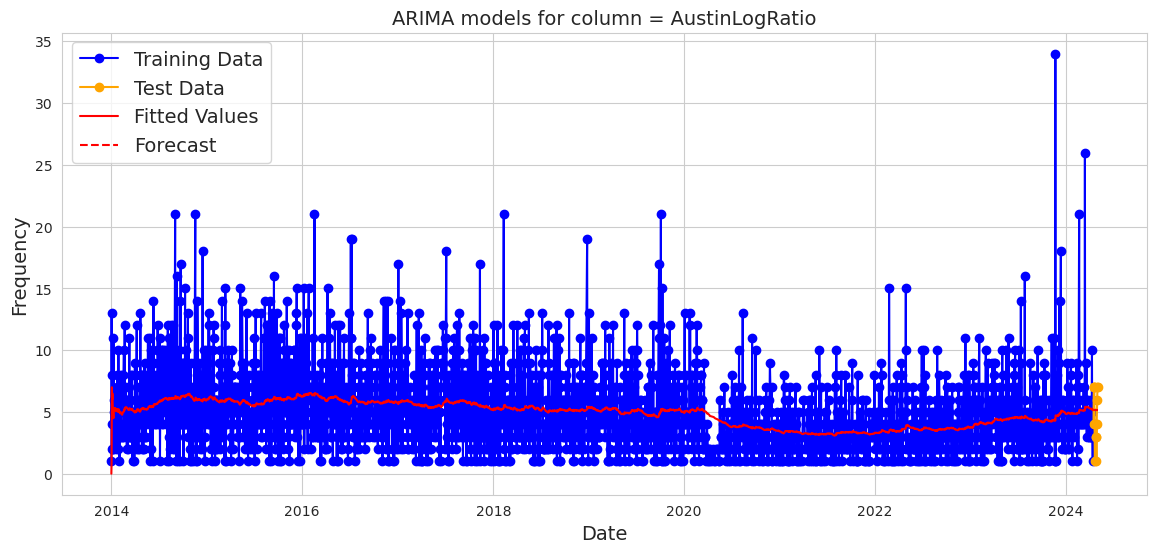

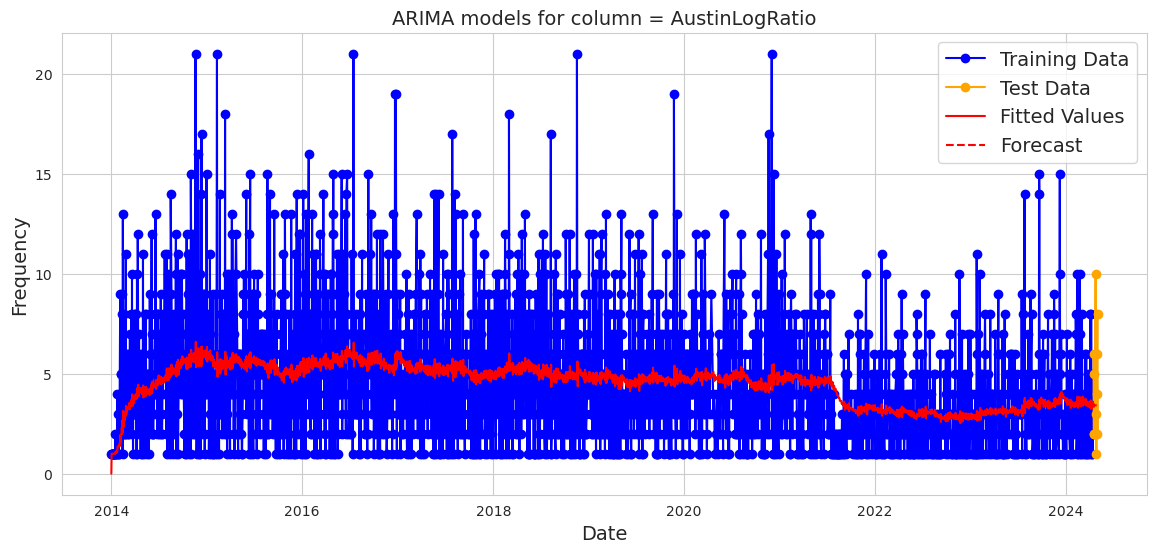

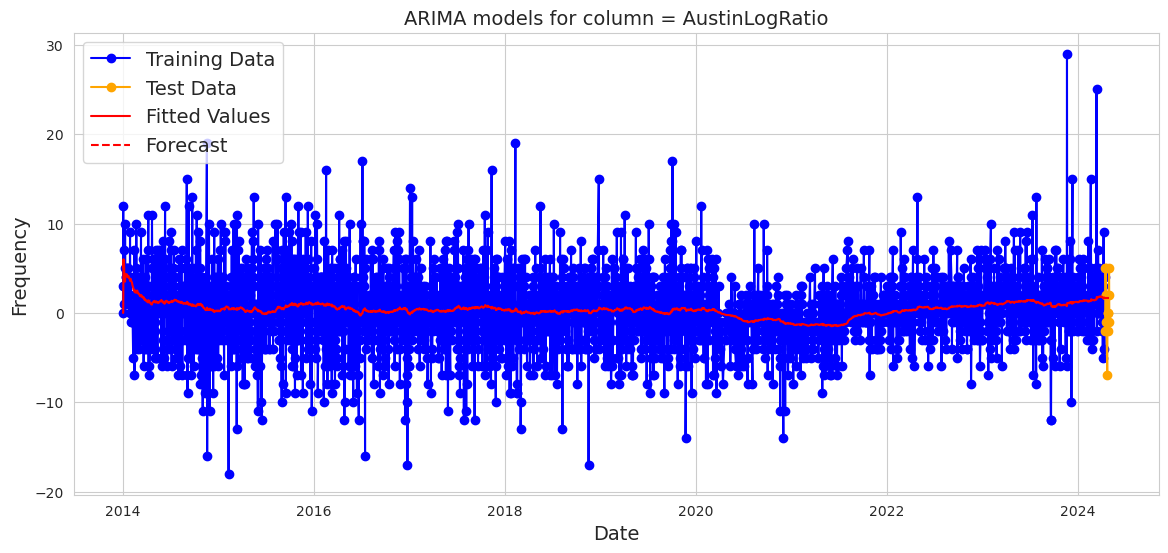

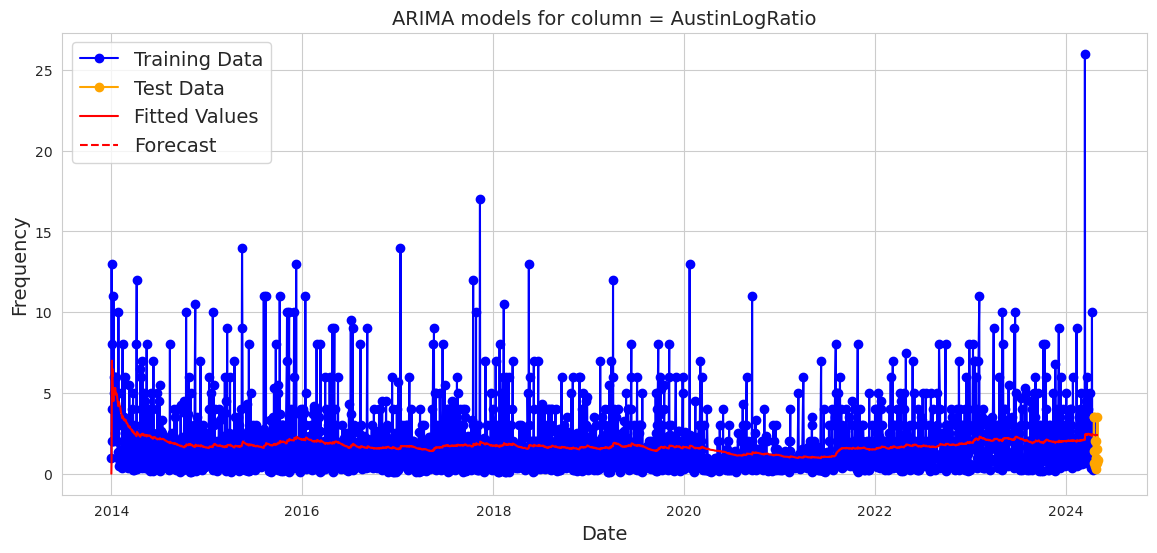

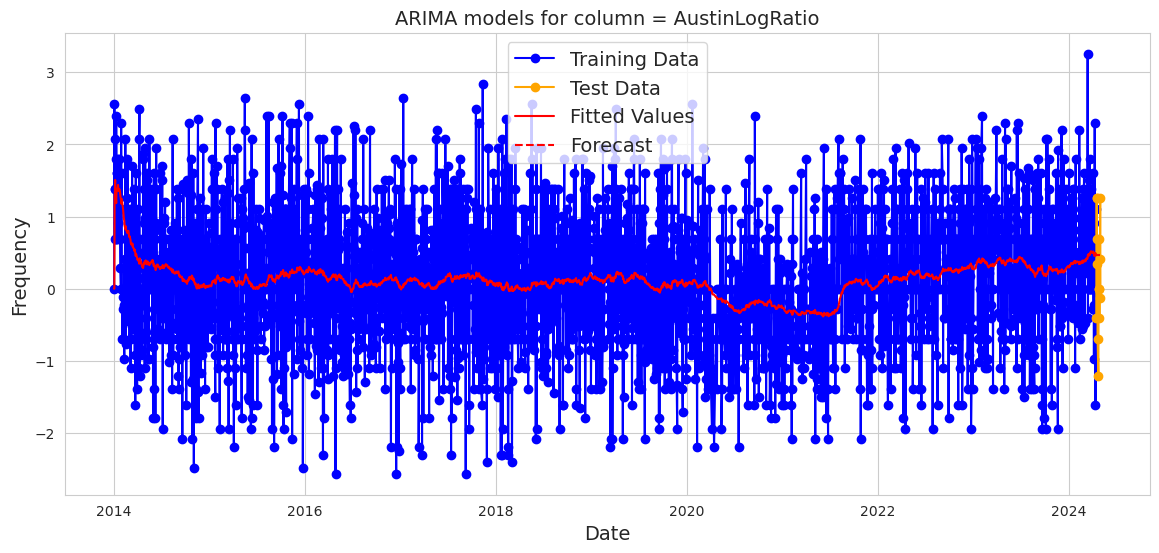

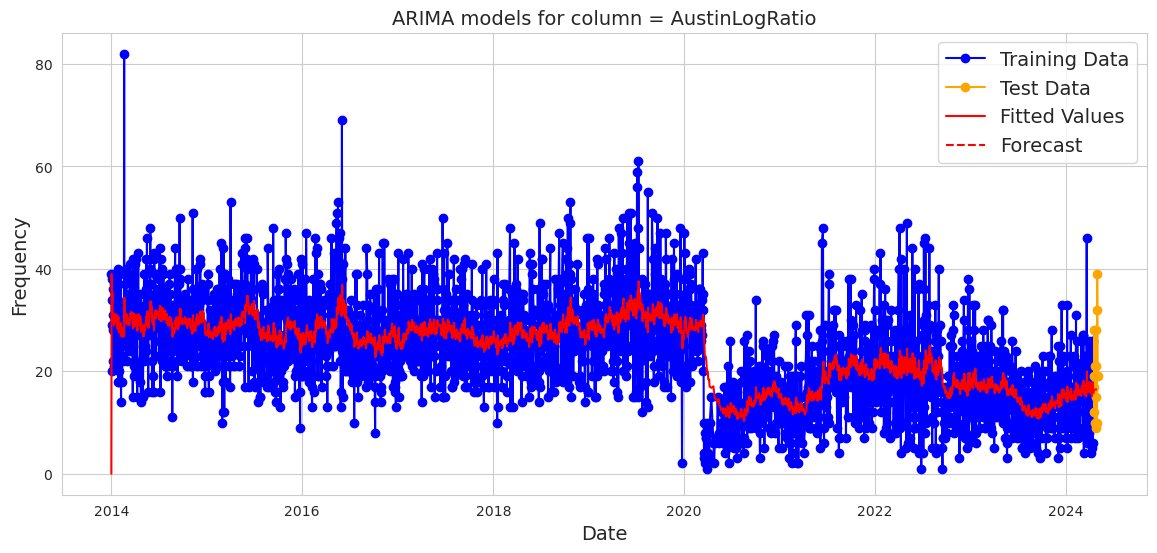

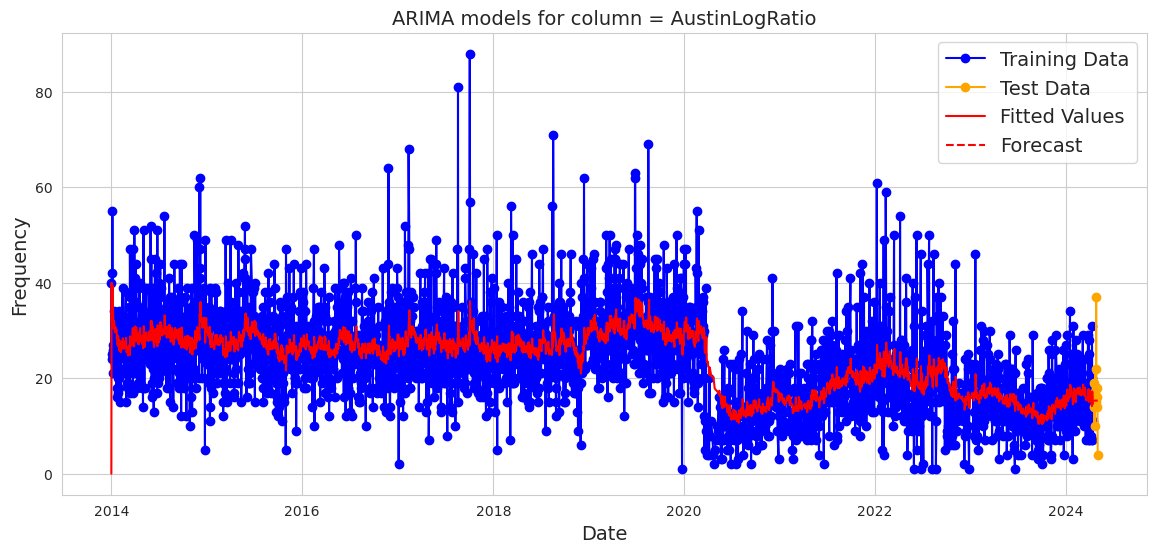

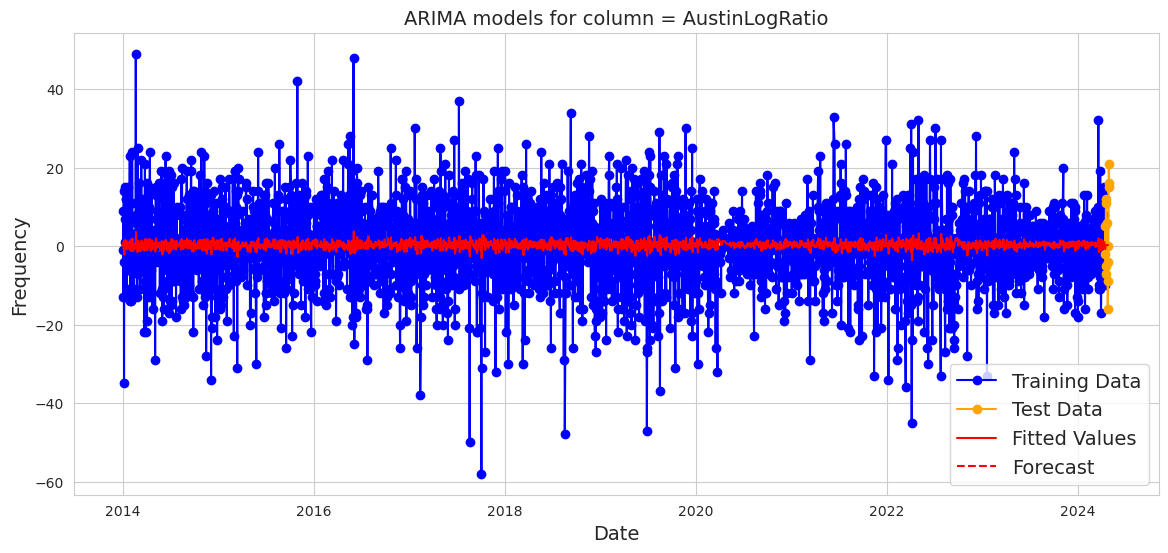

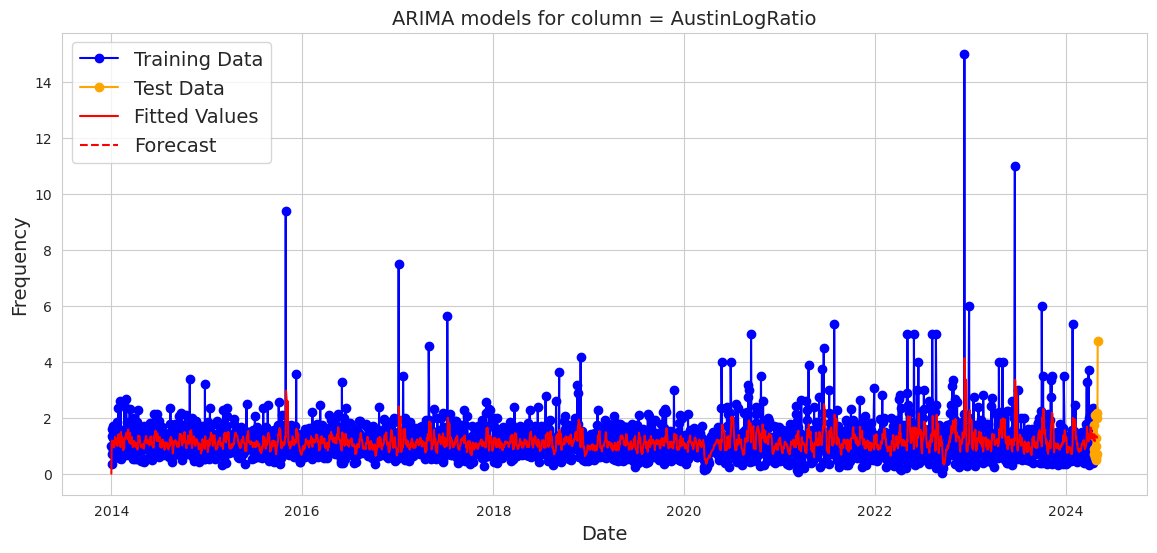

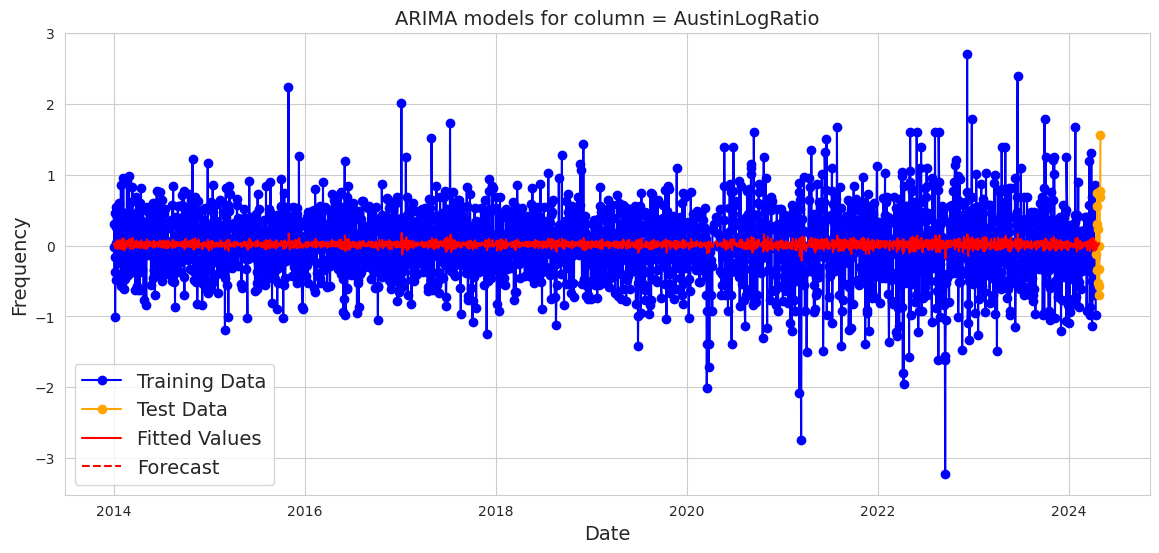

In [22]:
for i in range(len(col_list)):
    plt.figure(figsize=(14,6))

    plt.plot(df_train["Date"],
                df_train[col_list[i]],
                'b-o',
                label='Training Data')

    plt.plot(df_test["Date"],
                df_test[col_list[i]],
                color = 'orange',
                marker = 'o',
                label='Test Data')

    plt.plot(df_train["Date"],
                arima_models[i].fittedvalues,
                'r',
                label='Fitted Values')

    plt.plot(df_test["Date"],
                arima_models[i].forecast(len(df_test)),
                '--r',
                label="Forecast")

    plt.title("ARIMA models for column = " + col, fontsize=14)
    plt.legend(fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)

    plt.show()

### Do the above for monthly

In [23]:
# Redo everything just in case

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

from datetime import datetime

set_style("whitegrid")

In [24]:
df = pd.read_csv("../main_data/CleanedDataOnePlace.csv", parse_dates=["Date"])
df = df.loc[(df["Date"] >= pd.Timestamp(year = 2014, month = 1,day=1) ) & (df["Date"] <= pd.Timestamp(year = 2024, month = 5,day=1) )]

/tmp/ipykernel_50890/837667854.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../main_data/CleanedDataOnePlace.csv", parse_dates=["Date"])


In [25]:
# create DF with year/month as column
df = df.groupby(df['Date'].dt.to_period('M'))[["SonomaIntakeTotals","SonomaOutcomeTotals","AustinIntakeTotal","AustinOutcomeTotal"]].sum().reset_index()

In [26]:
df["SonomaDifferences"] = df["SonomaIntakeTotals"] - df["SonomaOutcomeTotals"]
df["AustinDifferences"] = df["AustinIntakeTotal"] - df["AustinOutcomeTotal"]
df["SonomaRatio"] = df["SonomaIntakeTotals"] / df["SonomaOutcomeTotals"]
df["AustinRatio"] = df["AustinIntakeTotal"] / df["AustinOutcomeTotal"]
df["SonomaLogRatio"] = np.log(df["SonomaRatio"])
df["AustinLogRatio"] = np.log(df["AustinRatio"])

In [27]:
# convert Period to Timestamp
df["Date"] = df["Date"].dt.to_timestamp()

# remove first and last row of df since ratio/diff have odd behaviours
df = df[1:-1]

In [28]:
col_list = ["SonomaIntakeTotals", "SonomaOutcomeTotals","SonomaDifferences","SonomaRatio", "SonomaLogRatio","AustinIntakeTotal","AustinOutcomeTotal","AustinDifferences","AustinRatio", "AustinLogRatio"]

In [29]:
monthly_maxmindiff = (df[col_list].max(axis=0) - df[col_list].min(axis=0))

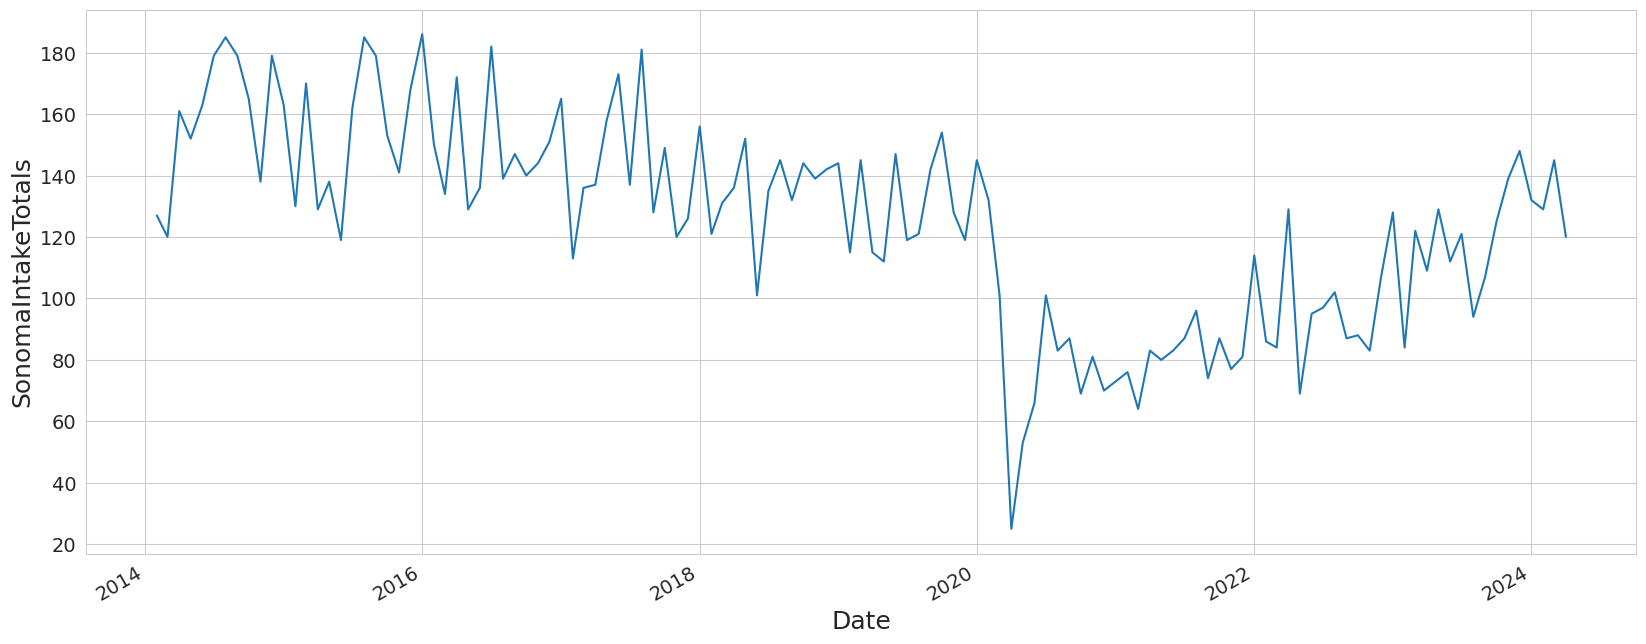

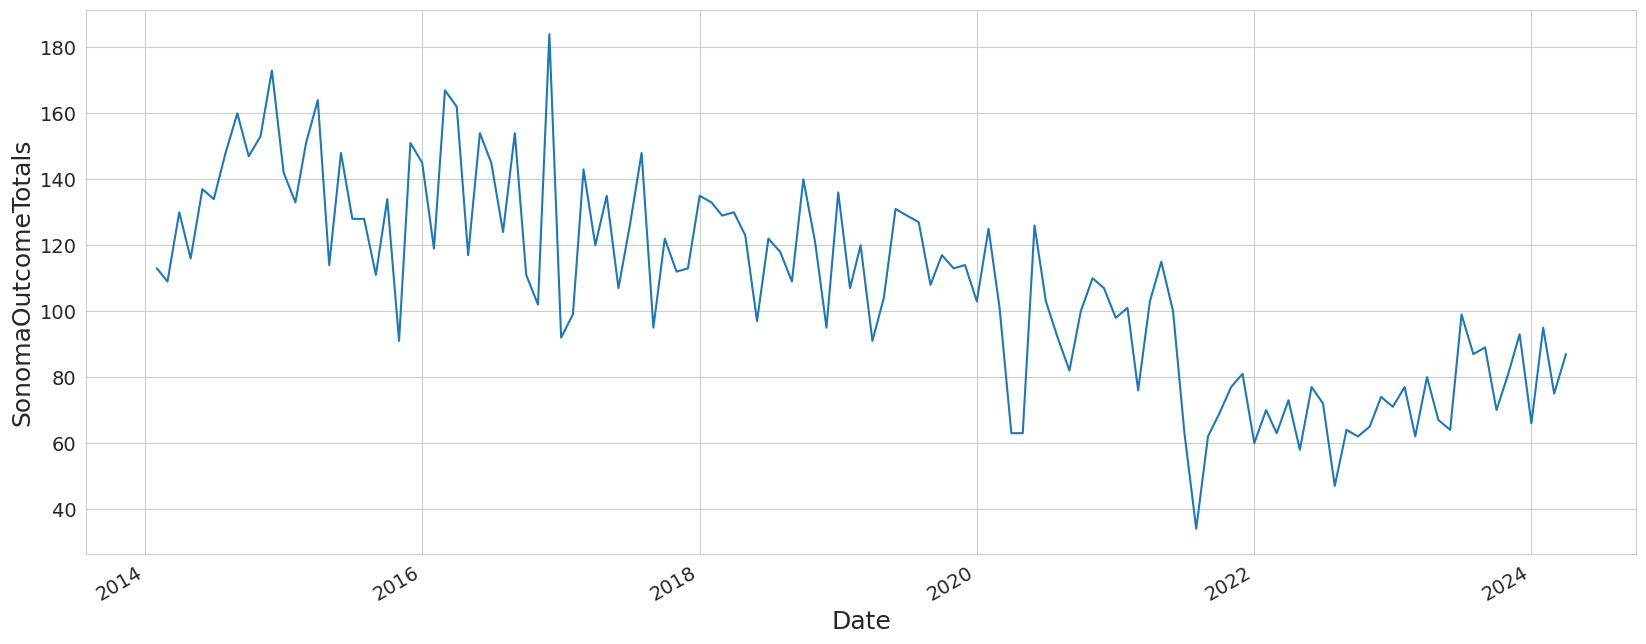

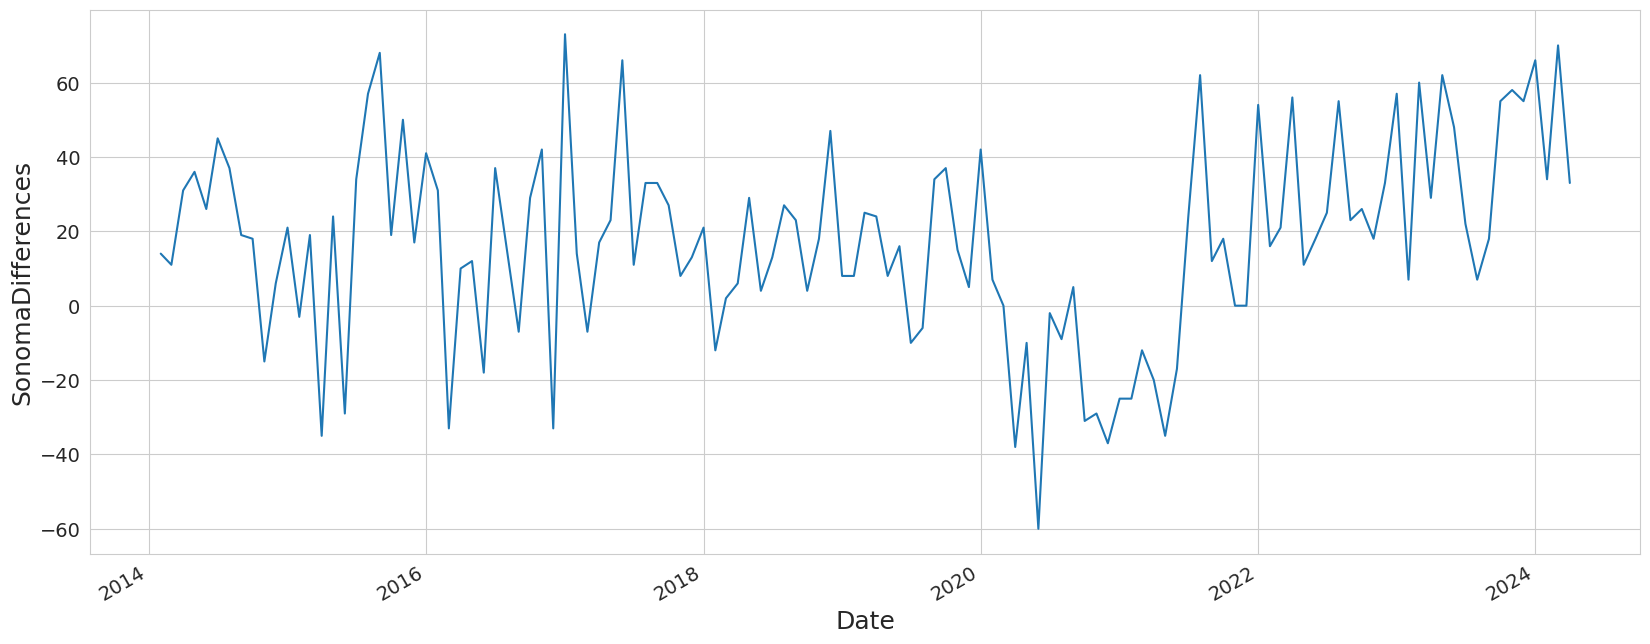

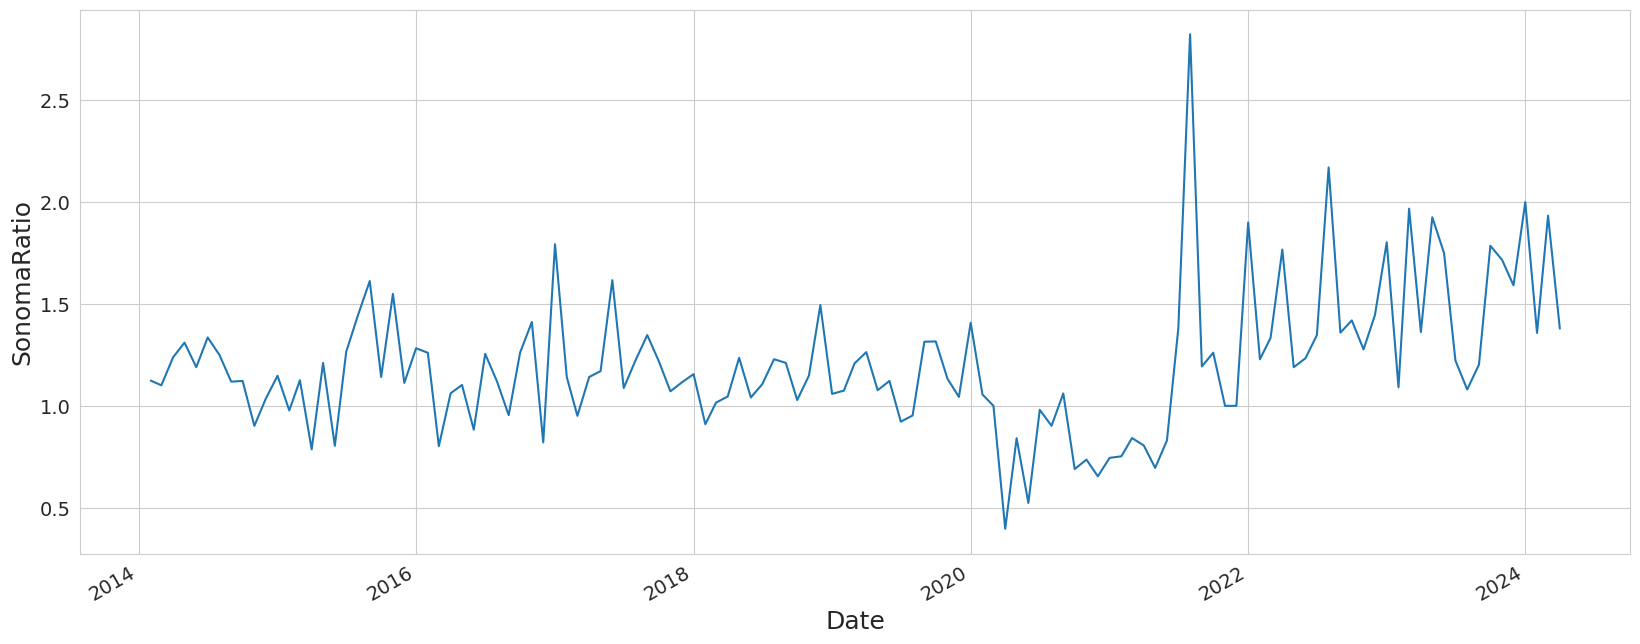

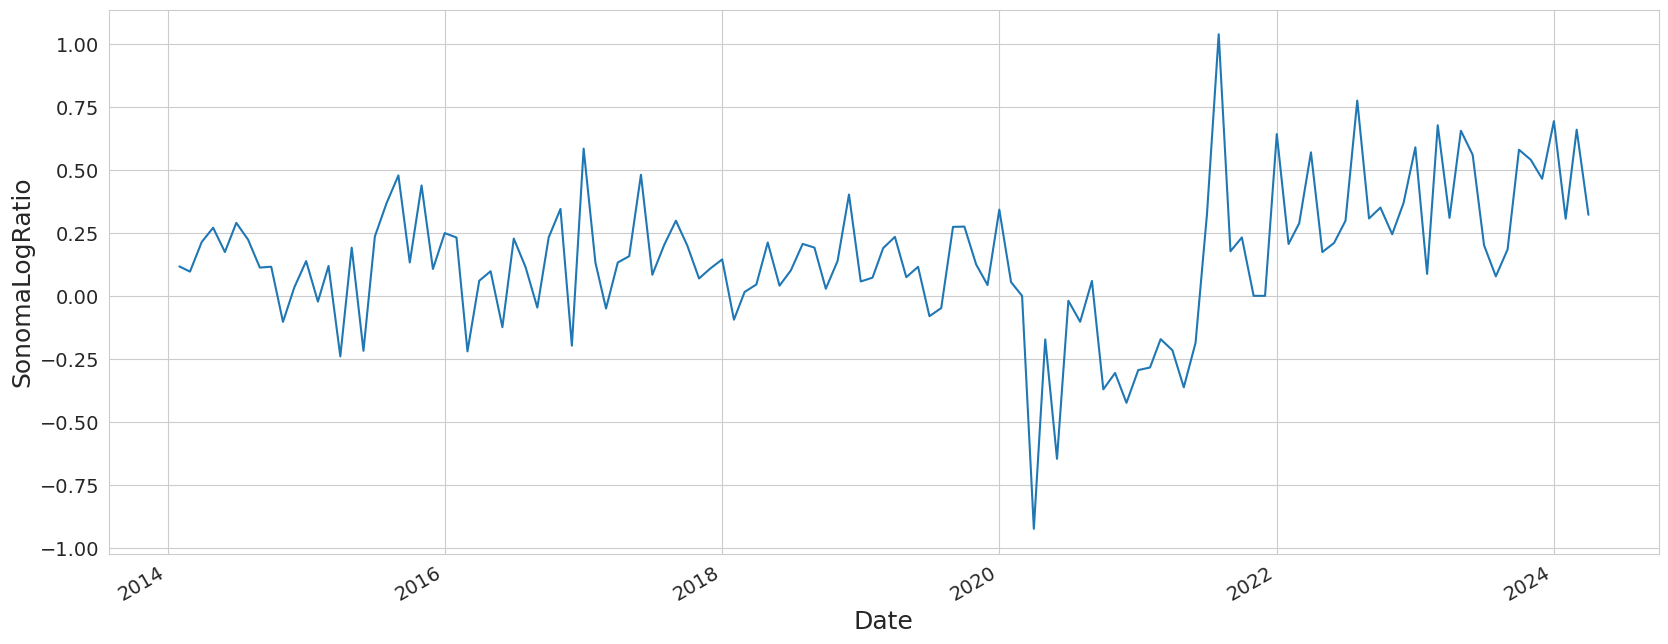

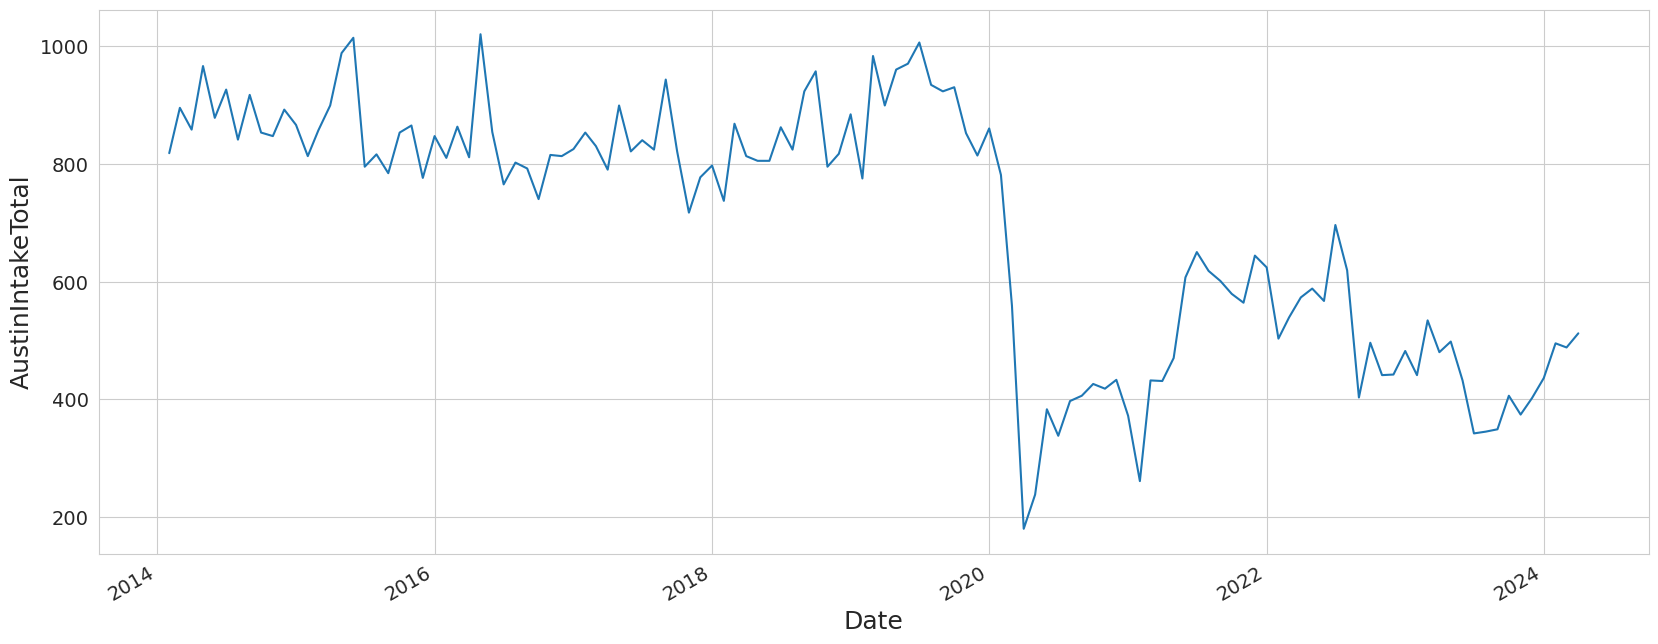

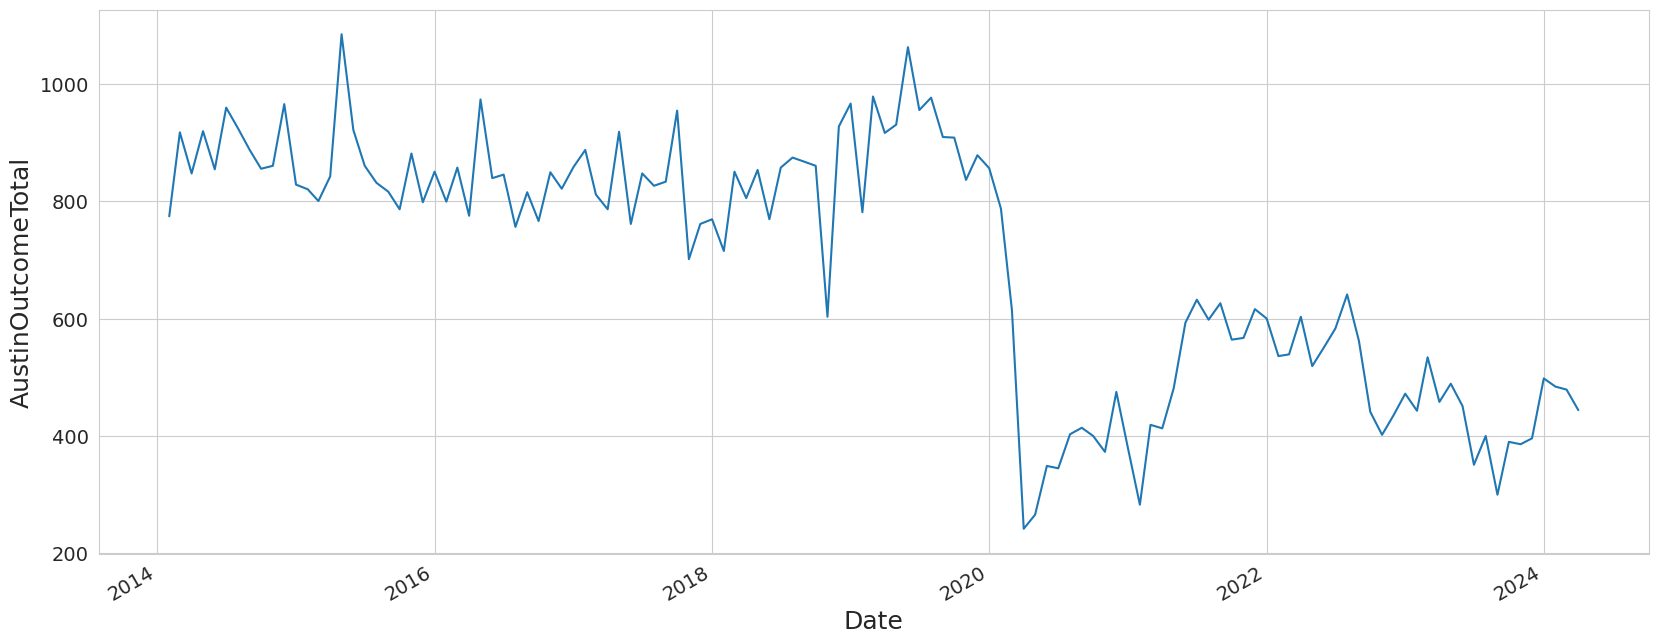

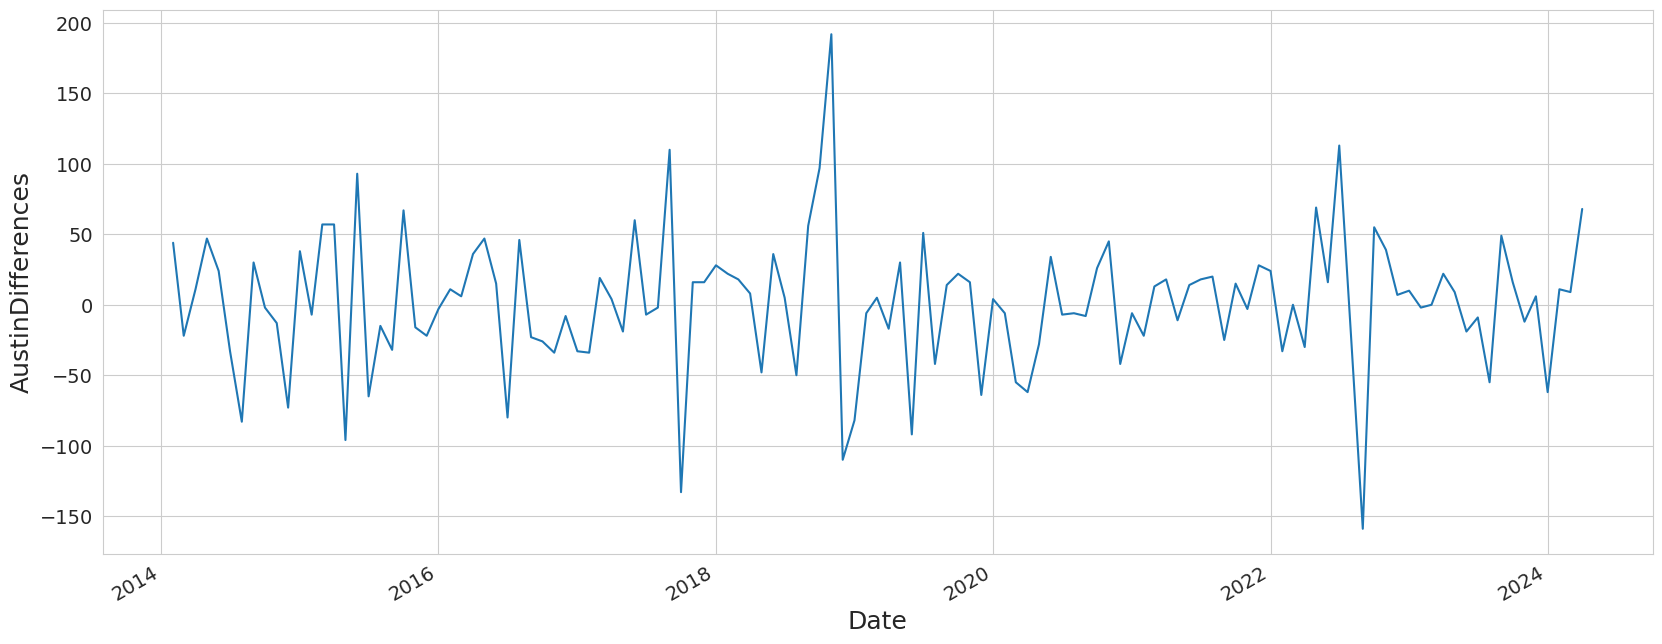

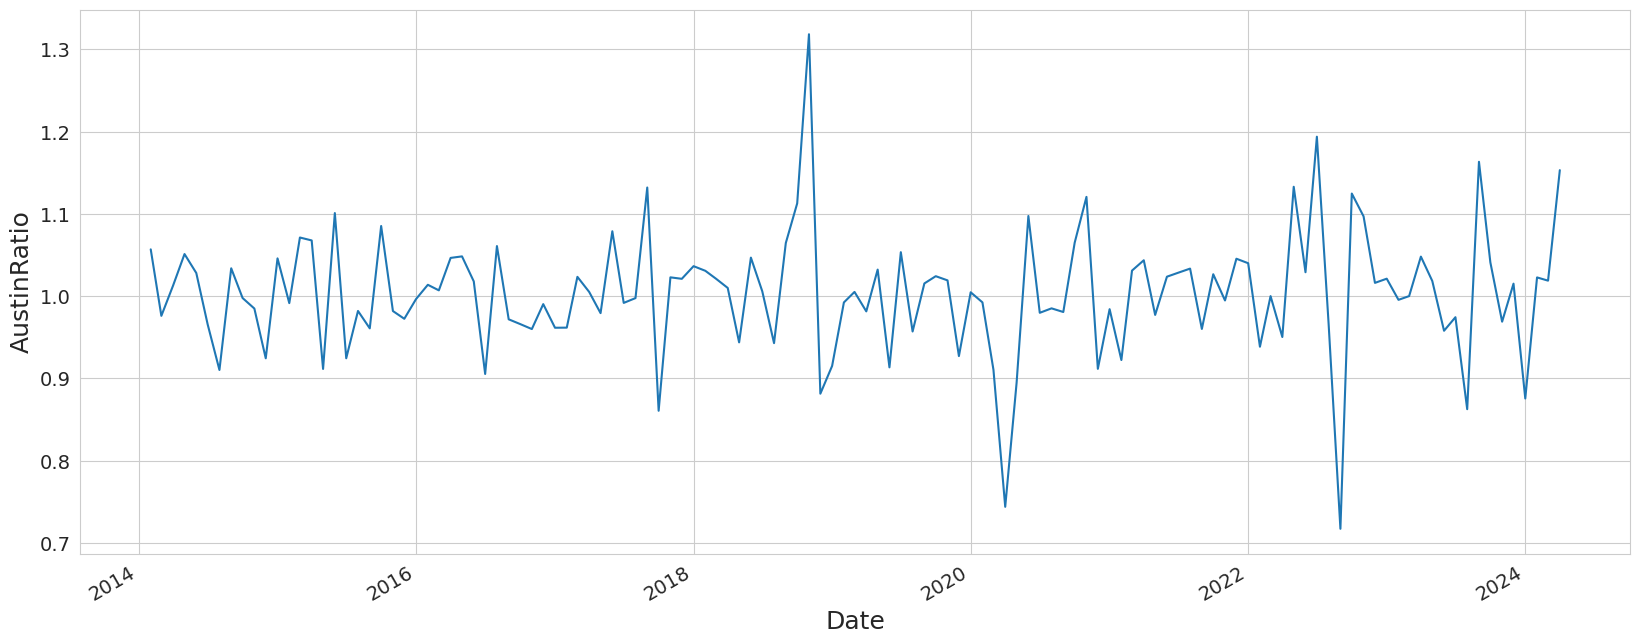

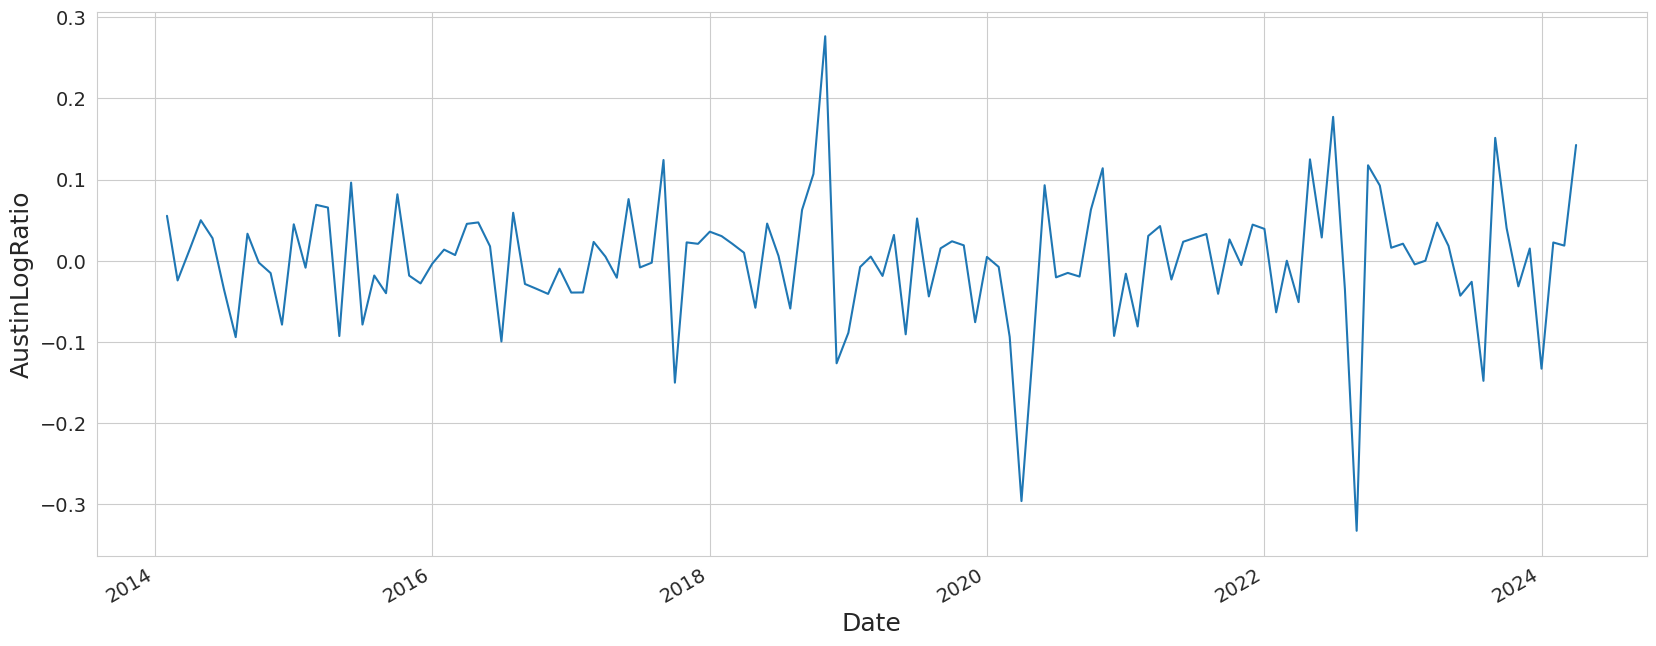

In [30]:
for col in col_list:
    plt.figure(figsize=(20,8))
    plt.plot(df["Date"], df[col])

    plt.xlabel("Date", fontsize=18)
    plt.ylabel(col, fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gcf().autofmt_xdate()

    plt.show()

In [31]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [32]:
# k = 5
# test size = 14 days
kfold = TimeSeriesSplit(n_splits = 5,
                           test_size = 3)

In [33]:
df_train = df.iloc[:-3].copy()
df_test = df.drop(df_train.index).copy()

In [34]:
# Baseline models
avg_rmses= np.zeros((10,5))
naive_rmses= np.zeros((10,5))
slr_rmses= np.zeros((10,5))
rw_drift_rmses= np.zeros((10,5))

i = 0
for train_index, test_index in kfold.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    for j in range(len(col_list)):
        
        # 1. Average forecast
        # forecast using average of training set
        df_tt_avg = df_tt[col_list[j]].mean()
        avg_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]].values, df_tt_avg*np.ones(len(df_ho))))
        
        # 2. Naive forecast
        # forecast using last value of training set
        df_tt_naive = df_tt[col_list[j]].values[-1]
        naive_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]].values, df_tt_naive*np.ones(len(df_ho))))
        
        
        # 3. Linear trend forecast
        # coefficients estimated through linear regression on training set
        slr = LinearRegression()
        slr.fit(np.array(df_tt.index).reshape(-1,1),
                df_tt[col_list[j]])
        pred = slr.predict(np.array(df_ho.index).reshape(-1,1))
        slr_rmses[j,i] = np.sqrt(mean_squared_error( df_ho[col_list[j]], pred))
        
        # 4. (Gaussian) random walk with drift
        beta_hat = (df_tt[col_list[j]].values[-1] - df_tt[col_list[j]].values[0])/len(df_tt)
        drift_pred = df_tt[col_list[j]].values[-1] + beta_hat*np.arange(1,len(df_ho) + 1)
        rw_drift_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]], drift_pred))
                
    i += 1
    
print(" Average: \n", avg_rmses.mean(axis=1))
print(" Naive: \n",naive_rmses.mean(axis=1))
print(" Linear: \n",slr_rmses.mean(axis=1))
print(" Random walk with drift: \n", rw_drift_rmses.mean(axis=1))

 Average: 
 [1.96849050e+01 3.60872367e+01 3.17115559e+01 4.84239588e-01
 3.57163137e-01 3.03622498e+02 3.03670774e+02 2.59968335e+01
 6.34481427e-02 6.37676955e-02]
 Naive: 
 [20.19319857 13.4118827  20.40869079  0.3278927   0.21360014 46.22261962
 48.57470513 34.87637353  0.08399462  0.08289135]
 Linear: 
 [3.87446746e+01 1.31247648e+01 3.44350122e+01 4.29434192e-01
 3.36411388e-01 6.87671687e+01 7.38965582e+01 2.62564006e+01
 6.42116161e-02 6.46595785e-02]
 Random walk with drift: 
 [20.39044153 13.70992627 20.3112908   0.327636    0.21345031 46.85902242
 50.14093512 34.85887746  0.08436462  0.08322878]


In [35]:
import statsmodels.api as sm

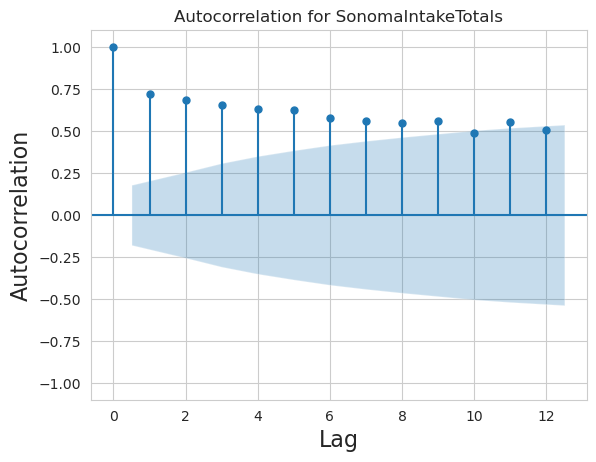

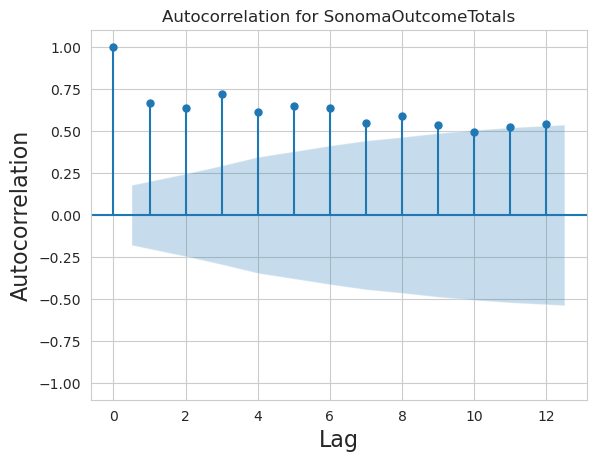

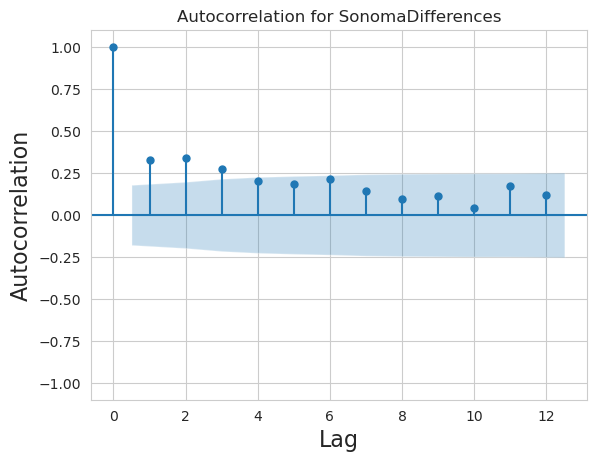

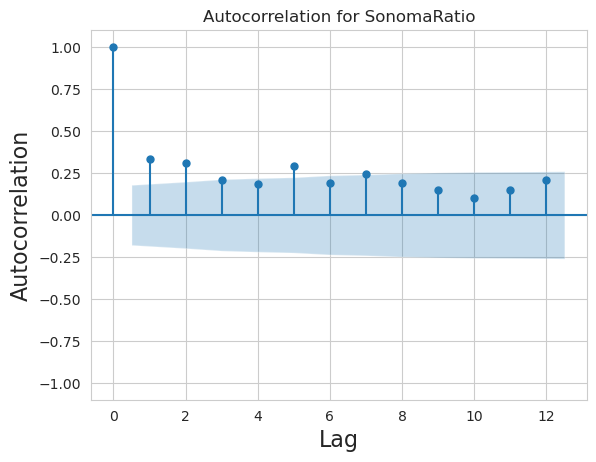

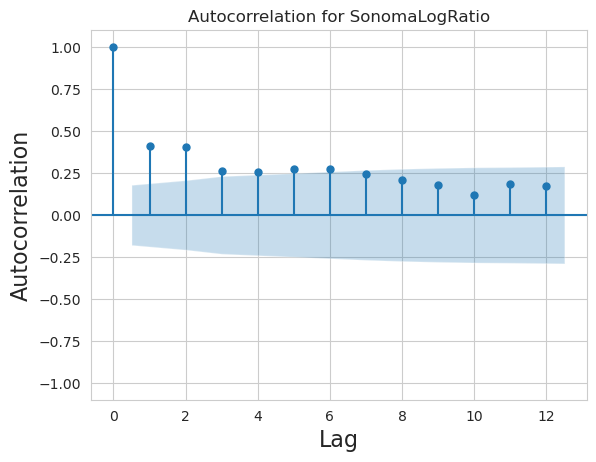

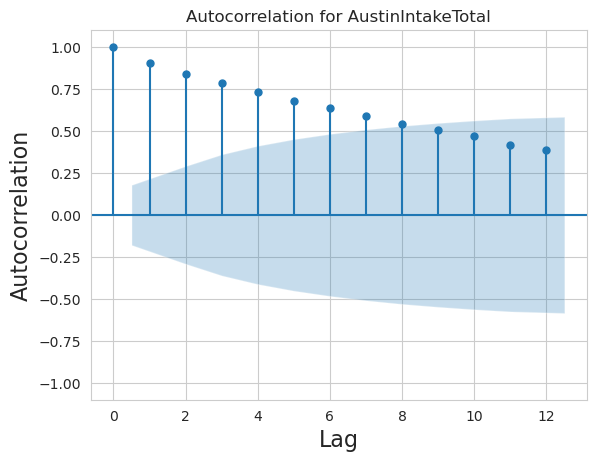

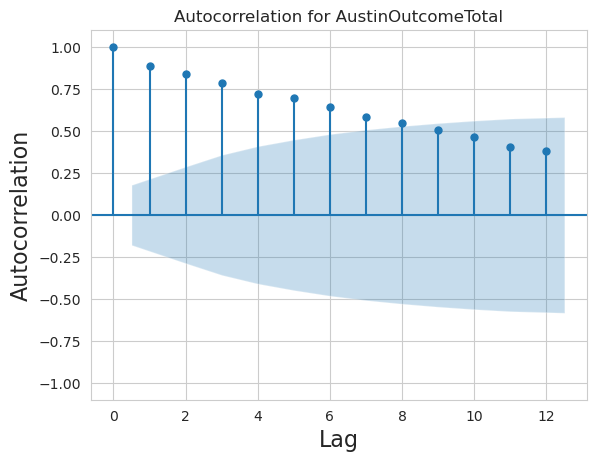

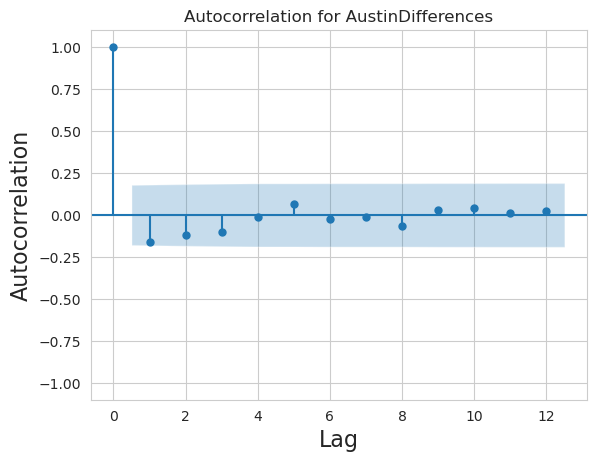

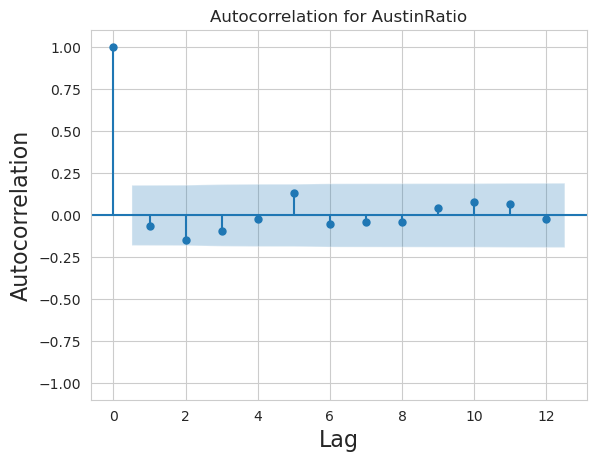

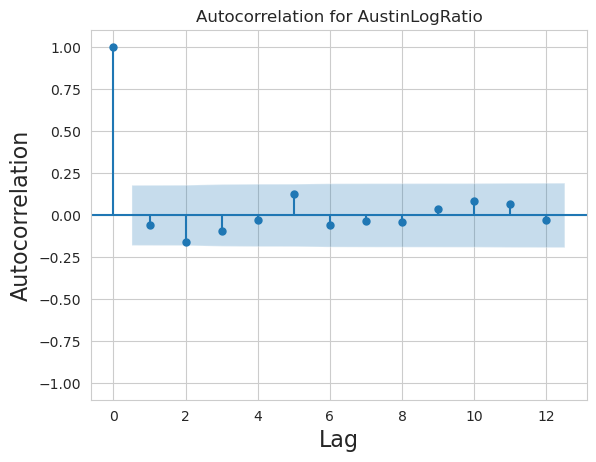

In [36]:
# Autocorrelation plots for starionarity and autocorrelation
for col in col_list:
    sm.graphics.tsa.plot_acf(df_train[col],
                                lags = 12)

    plt.title('Autocorrelation for ' + col, fontsize=12)
    plt.ylabel("Autocorrelation", fontsize=16)
    plt.xlabel("Lag", fontsize=16)

    plt.ylim(-1.1,1.1)

    plt.show()

### Observations:

Monthly is more interesting.

- both intakes/outcomes for Sonoma/Austing exhibit trend (slow decline of autocorrelation) and (weak) seasonality
- differences/ratios/logratios are random but exhibit (very weak) seasonality

In [37]:
#use auto_arima to find the optimal hyperparameters
from pmdarima import auto_arima
import statsmodels.tsa.api as sm

In [38]:
for i in range(len(col_list)):
    print(col_list[i])
    auto_arima(df_train[col_list[i]], trace=True)

SonomaIntakeTotals
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1074.804, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1108.917, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1085.731, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1070.921, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1106.918, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1072.349, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1072.399, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1072.864, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1068.946, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1070.415, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1070.457, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1083.735, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1070.900, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.319 seconds
Son

In [39]:
# ARIMA hyperparameters from the above cell
sonoma_intake_arima_model = sm.ARIMA(df_train["SonomaIntakeTotals"], order = (0,1,1)).fit()
sonoma_outcome_arima_model = sm.ARIMA(df_train["SonomaOutcomeTotals"], order = (0,1,1)).fit()
sonoma_diff_arima_model = sm.ARIMA(df_train["SonomaDifferences"], order = (1,0,1)).fit()
sonoma_ratio_arima_model = sm.ARIMA(df_train["SonomaRatio"], order = (0,1,1)).fit()
sonoma_logratio_arima_model = sm.ARIMA(df_train["SonomaLogRatio"], order = (1,0,1)).fit()
austin_intake_arima_model = sm.ARIMA(df_train["AustinIntakeTotal"], order = (0,1,1)).fit()
austin_outcome_arima_model = sm.ARIMA(df_train["AustinOutcomeTotal"], order = (0,1,1)).fit()
austin_diff_arima_model = sm.ARIMA(df_train["AustinDifferences"], order = (1,0,1)).fit()
austin_ratio_arima_model = sm.ARIMA(df_train["AustinRatio"], order = (0,0,0)).fit()
austin_logratio_arima_model = sm.ARIMA(df_train["AustinLogRatio"], order = (0,0,0)).fit()

arima_models = [sonoma_intake_arima_model,
                sonoma_outcome_arima_model,
                sonoma_diff_arima_model,
                sonoma_ratio_arima_model,
                sonoma_logratio_arima_model,
                austin_intake_arima_model,
                austin_outcome_arima_model,
                austin_diff_arima_model,
                austin_ratio_arima_model,
                austin_logratio_arima_model]

/home/jun/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [40]:
# Record ARIMA rmse's
arima_rmses= np.zeros((10,5))

i = 0
for train_index, test_index in kfold.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    for j in range(len(col_list)):
        
        # ARIMA forecast
        arima_rmses[j,i] = np.sqrt(mean_squared_error(df_ho[col_list[j]].values, arima_models[j].forecast(len(df_ho))))
                
    i += 1

RMSE's of models used:

In [41]:
print(" Average: \n", avg_rmses.mean(axis=1))
print(" Naive: \n",naive_rmses.mean(axis=1))
print(" Linear: \n",slr_rmses.mean(axis=1))
print(" Random walk with drift: \n", rw_drift_rmses.mean(axis=1))
print(" ARIMA: \n", arima_rmses.mean(axis=1))

 Average: 
 [1.96849050e+01 3.60872367e+01 3.17115559e+01 4.84239588e-01
 3.57163137e-01 3.03622498e+02 3.03670774e+02 2.59968335e+01
 6.34481427e-02 6.37676955e-02]
 Naive: 
 [20.19319857 13.4118827  20.40869079  0.3278927   0.21360014 46.22261962
 48.57470513 34.87637353  0.08399462  0.08289135]
 Linear: 
 [3.87446746e+01 1.31247648e+01 3.44350122e+01 4.29434192e-01
 3.36411388e-01 6.87671687e+01 7.38965582e+01 2.62564006e+01
 6.42116161e-02 6.46595785e-02]
 Random walk with drift: 
 [20.39044153 13.70992627 20.3112908   0.327636    0.21345031 46.85902242
 50.14093512 34.85887746  0.08436462  0.08322878]
 ARIMA: 
 [21.96652668 10.99306836 20.85506355  0.31566218  0.21256072 53.5969474
 62.73051994 27.06621702  0.06320697  0.06354329]


NRMSE's of models used (NRMSE = RMSE/max - min):

In [42]:
print(" Average: \n", avg_rmses.mean(axis=1)/monthly_maxmindiff)
print(" Naive: \n",naive_rmses.mean(axis=1)/monthly_maxmindiff)
print(" Linear: \n",slr_rmses.mean(axis=1)/monthly_maxmindiff)
print(" Random walk with drift: \n", rw_drift_rmses.mean(axis=1)/monthly_maxmindiff)
print(" ARIMA: \n", arima_rmses.mean(axis=1)/monthly_maxmindiff)

 Average: 
 SonomaIntakeTotals     0.122266
SonomaOutcomeTotals    0.240582
SonomaDifferences      0.238433
SonomaRatio            0.199546
SonomaLogRatio         0.182017
AustinIntakeTotal      0.361455
AustinOutcomeTotal     0.360654
AustinDifferences      0.074065
AustinRatio            0.105514
AustinLogRatio         0.104711
dtype: float64
 Naive: 
 SonomaIntakeTotals     0.125424
SonomaOutcomeTotals    0.089413
SonomaDifferences      0.153449
SonomaRatio            0.135119
SonomaLogRatio         0.108855
AustinIntakeTotal      0.055027
AustinOutcomeTotal     0.057690
AustinDifferences      0.099363
AustinRatio            0.139682
AustinLogRatio         0.136113
dtype: float64
 Linear: 
 SonomaIntakeTotals     0.240650
SonomaOutcomeTotals    0.087498
SonomaDifferences      0.258910
SonomaRatio            0.176962
SonomaLogRatio         0.171442
AustinIntakeTotal      0.081866
AustinOutcomeTotal     0.087763
AustinDifferences      0.074805
AustinRatio            0.106783
AustinLog

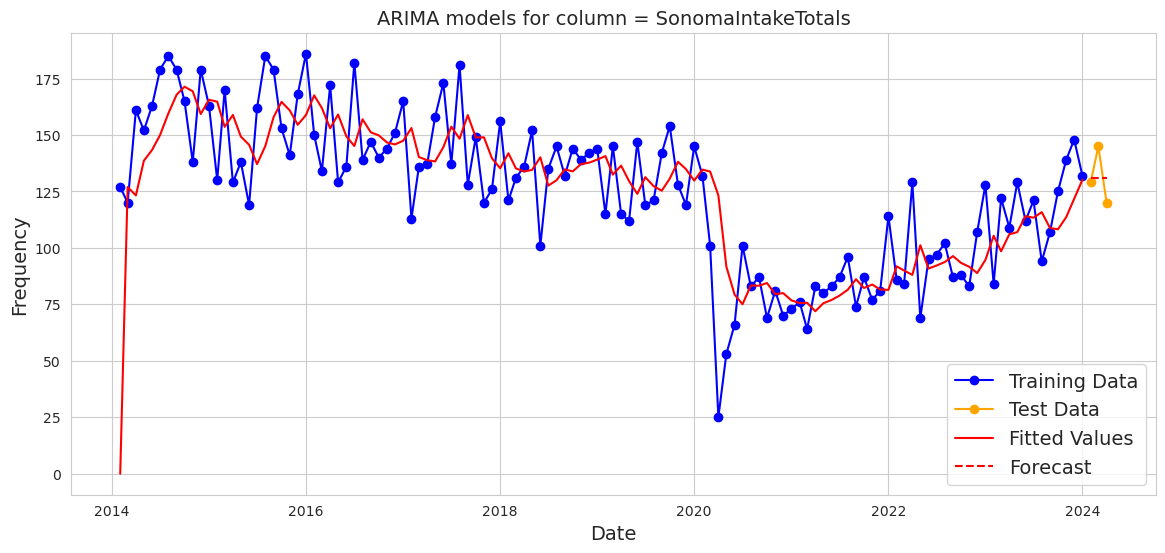

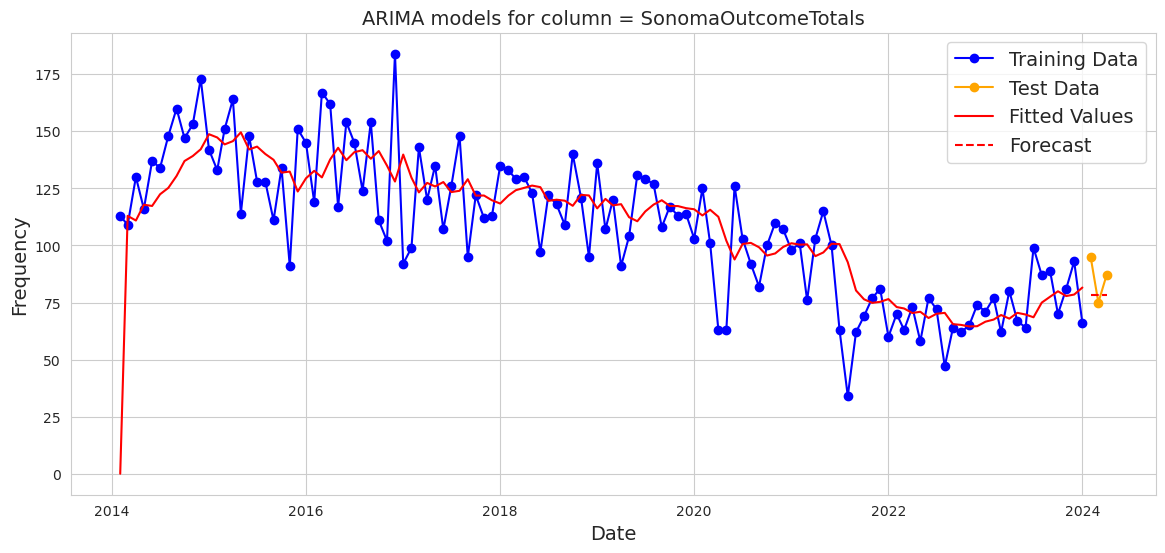

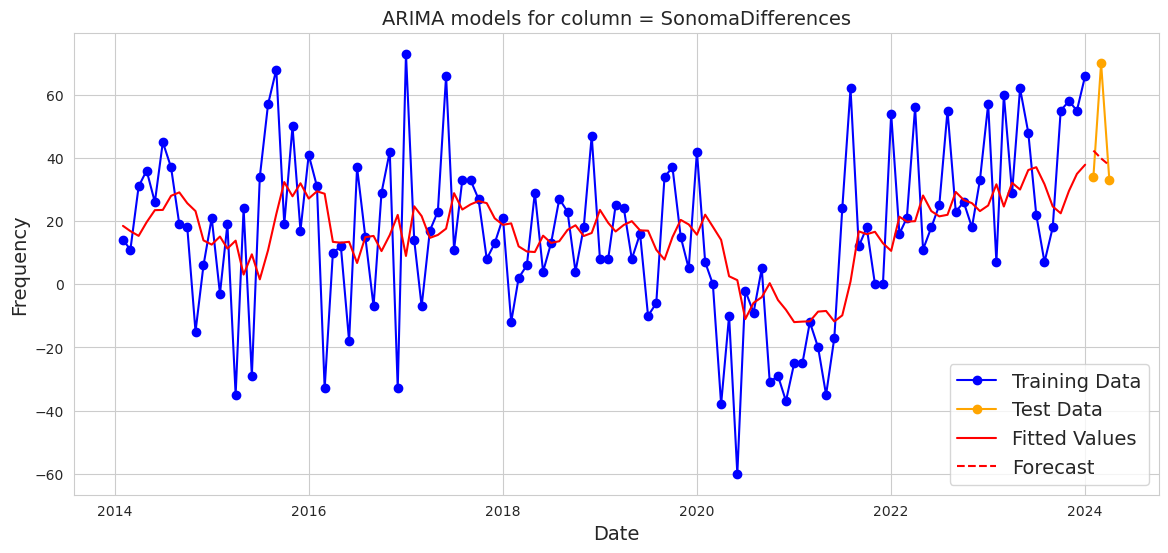

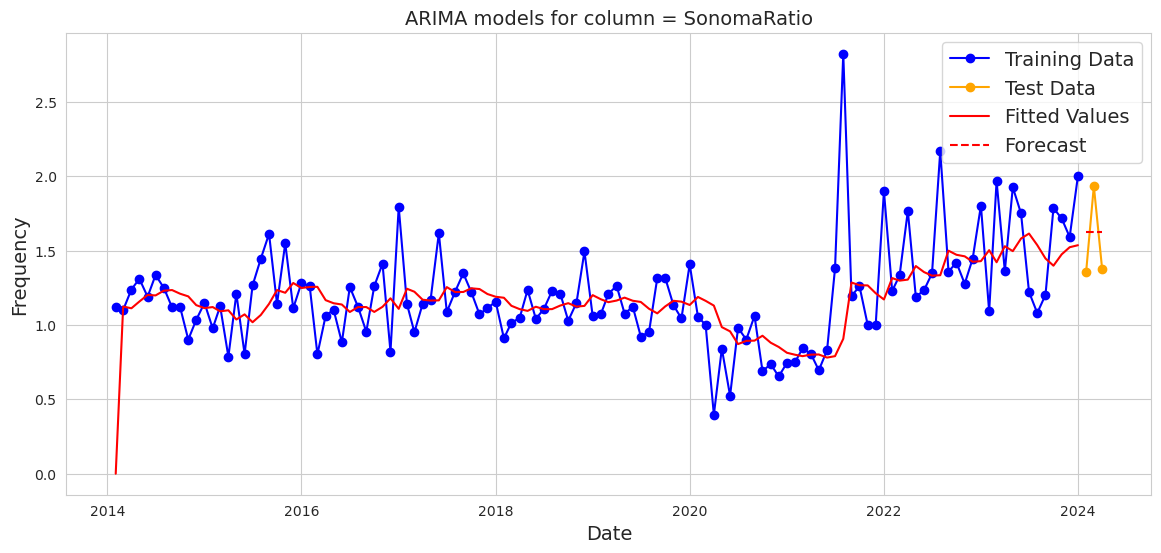

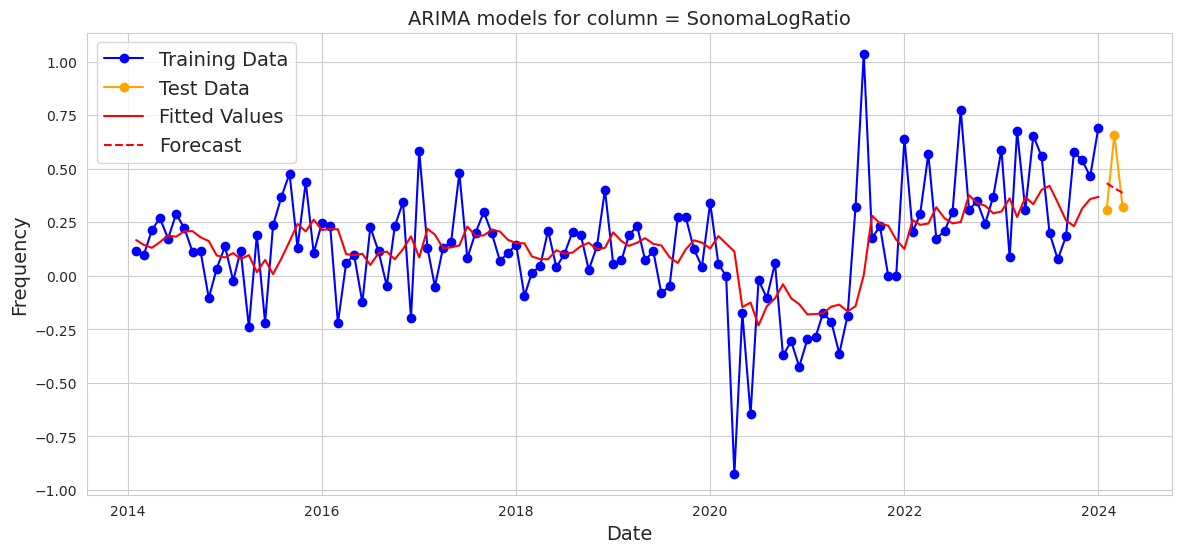

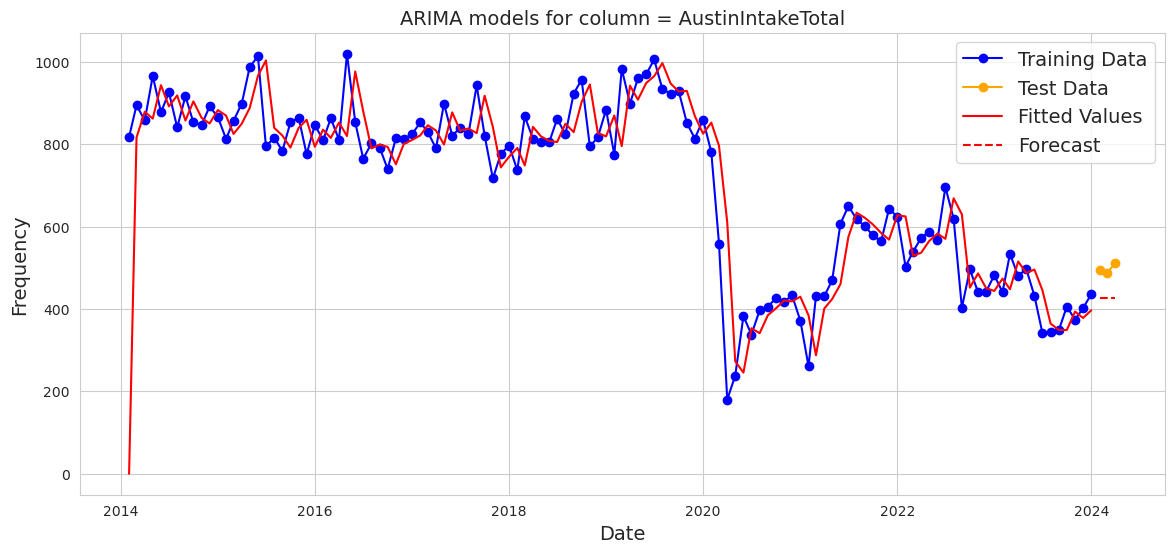

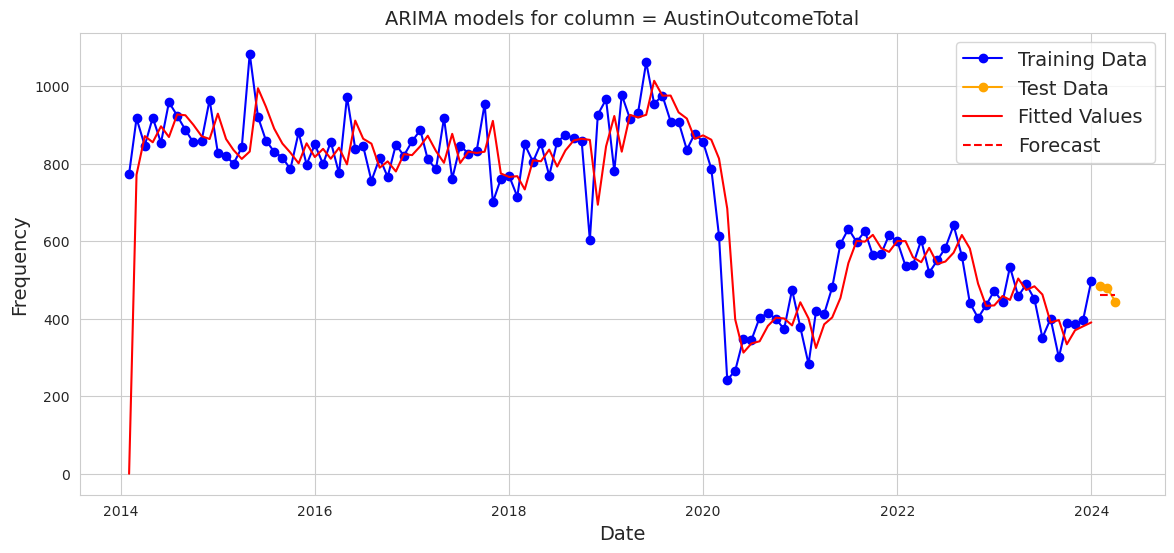

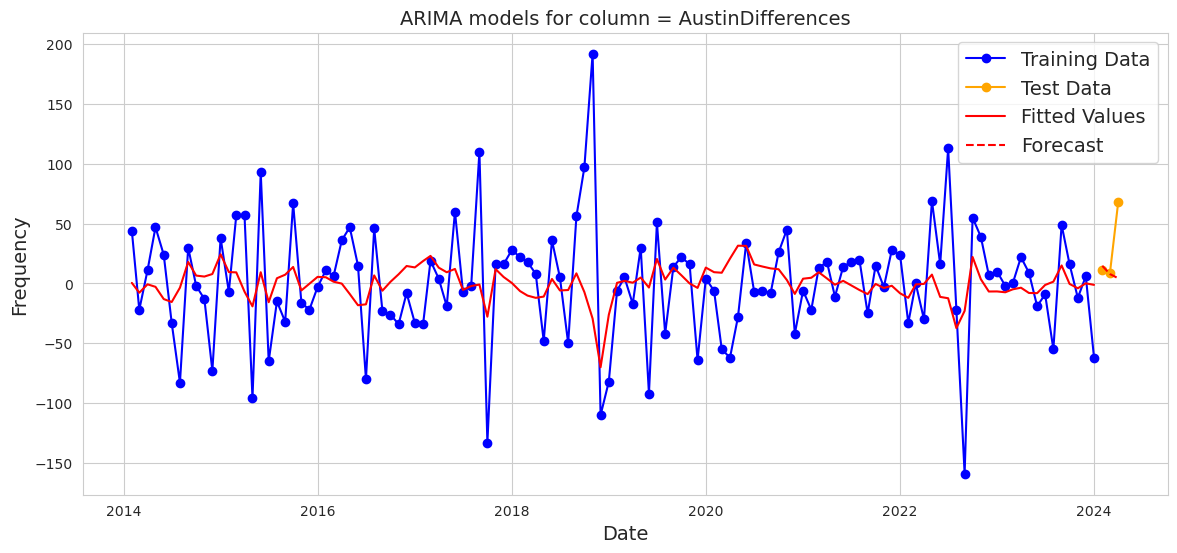

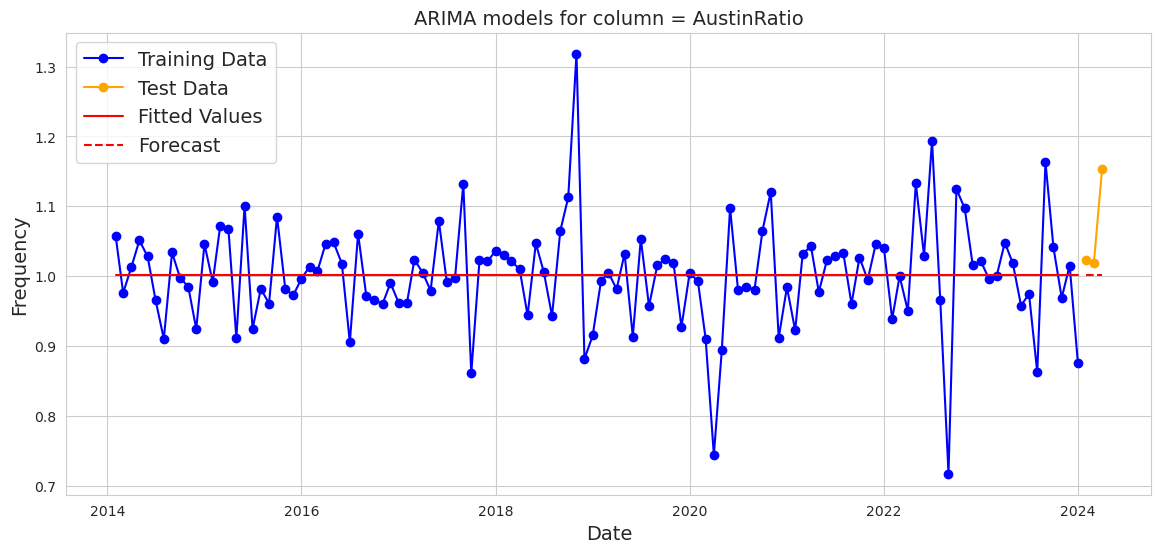

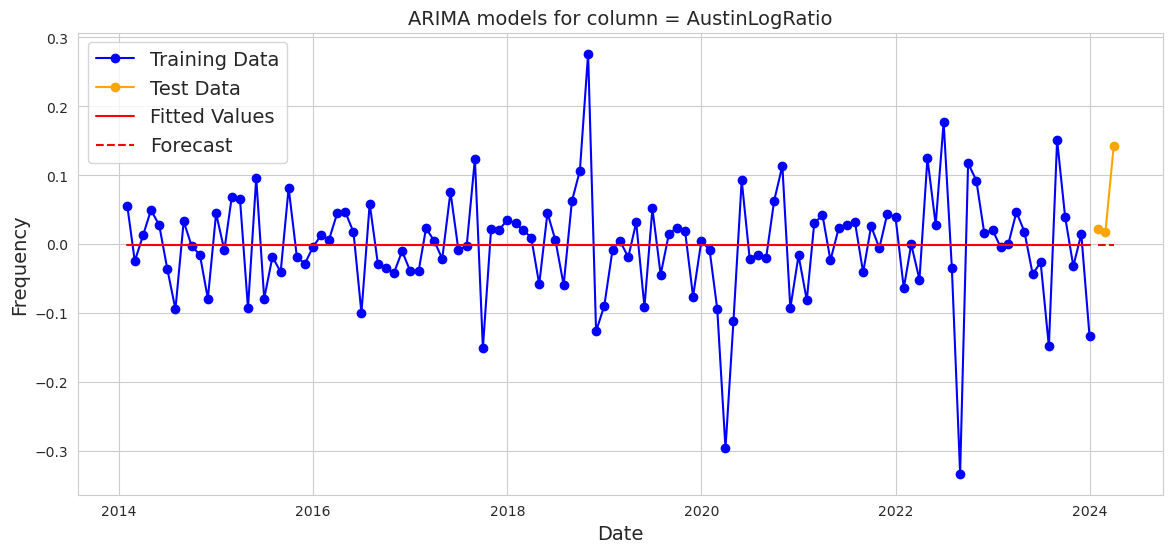

In [43]:
for i in range(len(col_list)):
    plt.figure(figsize=(14,6))

    plt.plot(df_train["Date"],
                df_train[col_list[i]],
                'b-o',
                label='Training Data')

    plt.plot(df_test["Date"],
                df_test[col_list[i]],
                color = 'orange',
                marker = 'o',
                label='Test Data')

    plt.plot(df_train["Date"],
                arima_models[i].fittedvalues,
                'r',
                label='Fitted Values')

    plt.plot(df_test["Date"],
                arima_models[i].forecast(len(df_test)),
                '--r',
                label="Forecast")

    plt.title("ARIMA models for column = " + col_list[i], fontsize=14)
    plt.legend(fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)

    plt.show()

In [44]:
# PACF plots
import statsmodels.api as sm

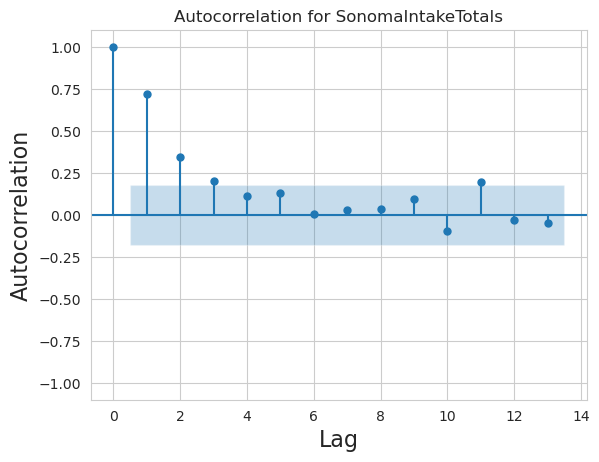

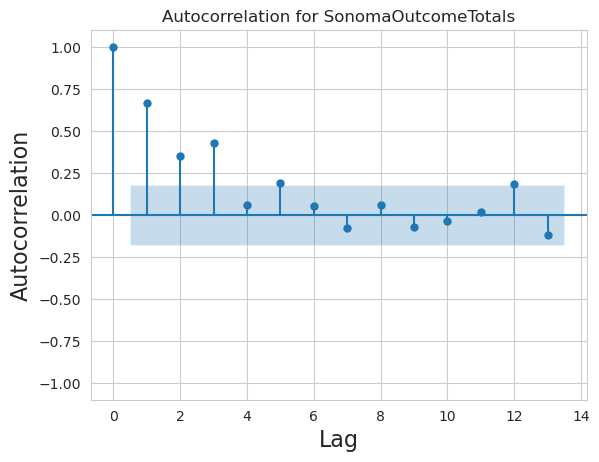

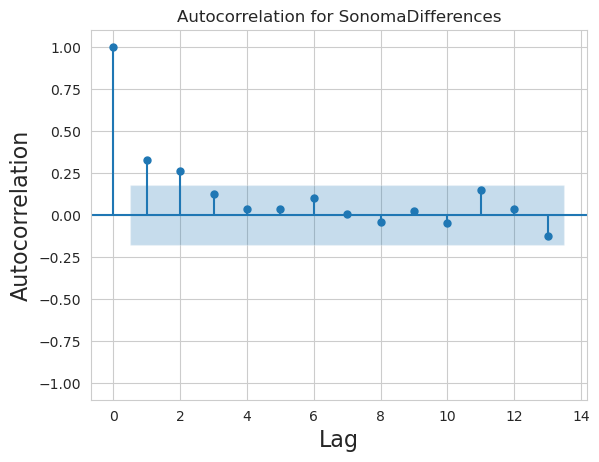

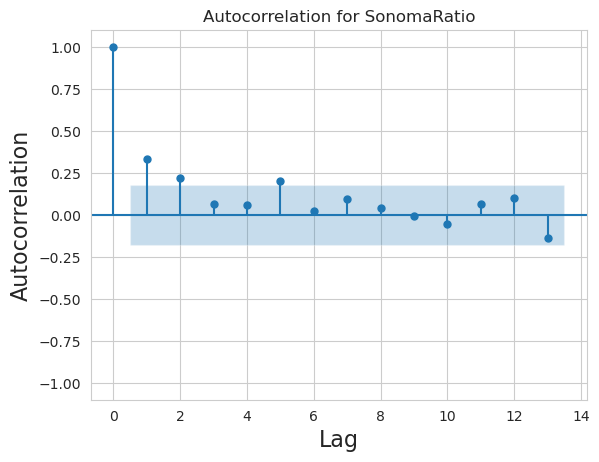

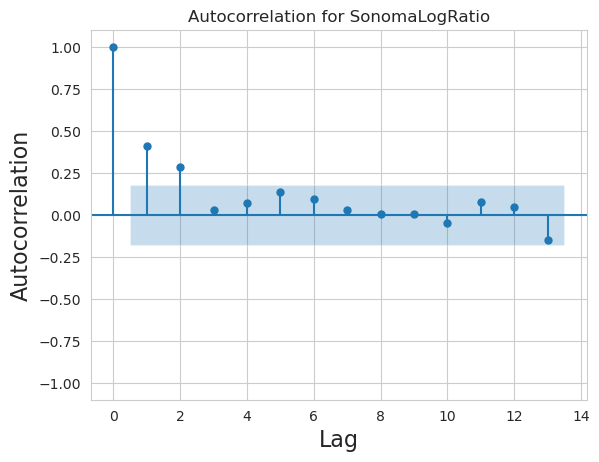

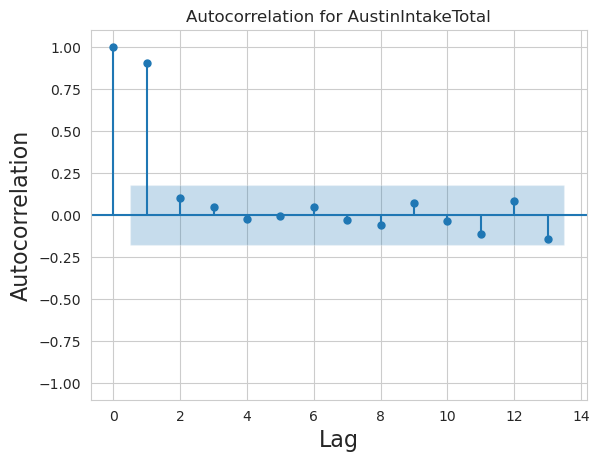

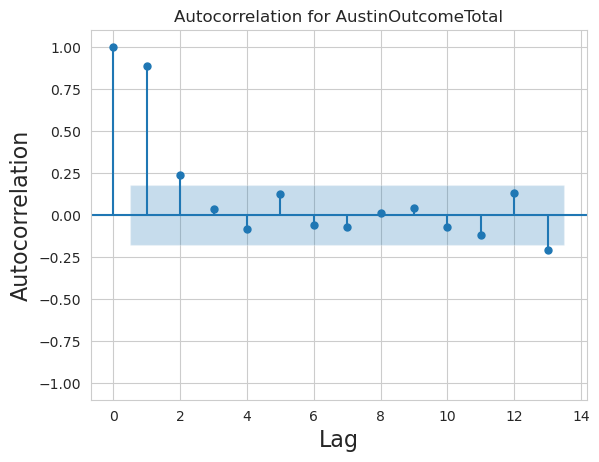

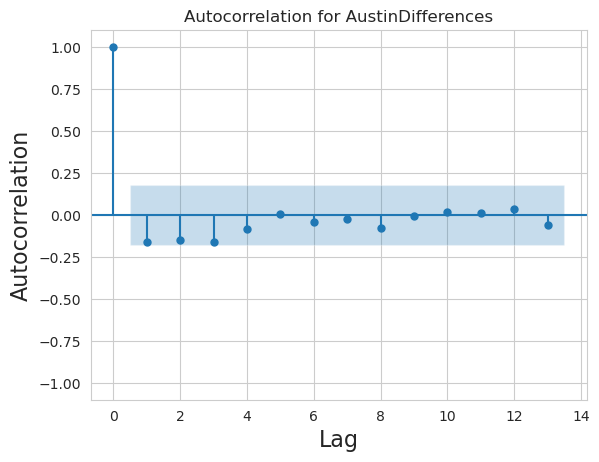

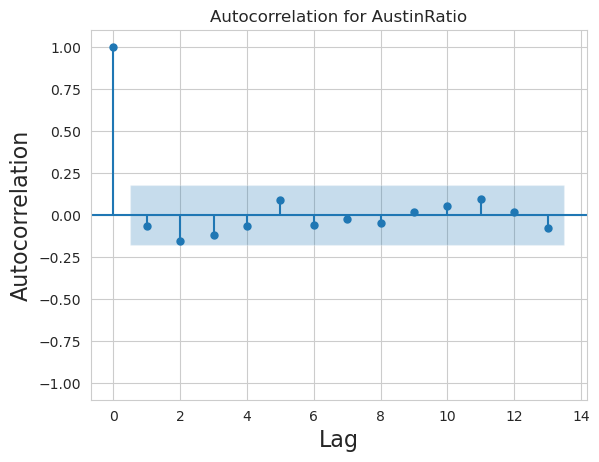

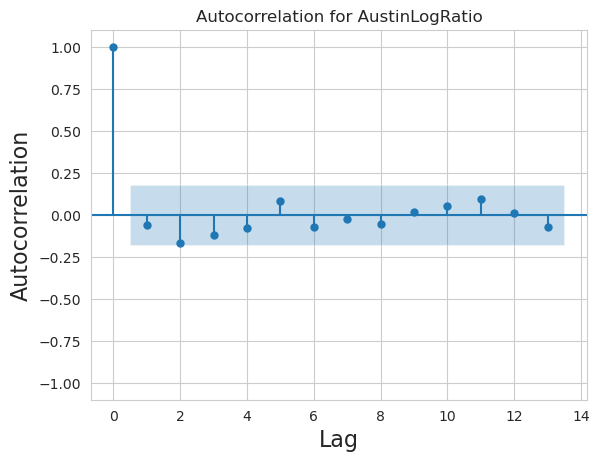

In [45]:
# Autocorrelation plots for starionarity and autocorrelation
for col in col_list:
    sm.graphics.tsa.plot_pacf(df_train[col],
                                lags = 13)

    plt.title('Autocorrelation for ' + col, fontsize=12)
    plt.ylabel("Autocorrelation", fontsize=16)
    plt.xlabel("Lag", fontsize=16)

    plt.ylim(-1.1,1.1)

    plt.show()

In [46]:
#use auto_arima to find the optimal hyperparameters
from pmdarima import auto_arima
import statsmodels.tsa.api as sm

In [47]:
#use auto_arima to find the optimal hyperparameters for SARIMA
for i in range(len(col_list)):
    print(col_list[i])
    auto_arima(df_train[col_list[i]], trace=True,seasonal=True, D = 1)

SonomaIntakeTotals
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1074.804, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1108.917, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1085.731, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1070.921, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1106.918, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1072.349, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1072.399, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1072.864, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1068.946, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1070.415, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1070.457, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1083.735, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1070.900, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.240 seconds
Son

Nothing significant for SARIMA auto_arima test

# TODO:
- implement EVA

## (3) Spicier stuff
- see [this paper on time series modelling with COVID-19](https://projecteuclid.org/journals/bayesian-analysis/advance-publication/Modeling-Extreme-Events-in-Time-Series-and-Their-Impact-on/10.1214/24-BA1424.full?tab=ArticleLink)